# <span style="font-size:1.5em;"> Forecasting Air Quality in New York City
Author: Angela Kim

---

# <span style="font-size:1.2em;"> Contents

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>
    
- <a href="#Business Problem">Business Problem</a>
    
- <a href="#Imports">Library Imports & Functions</a>

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>
    
- <a href="#Modeling">Modeling</a>

- <a href="#Visualizations">Visualizations</a>
    
- <a href="#Conclusion">Conclusion</a>

- <a href="#Next Steps">Next Steps</a>

---

# <span style="font-size:1.2em;"> <a id="Overview">Overview</a>

> This project analyzes air pollution data of four major gas pollutants--ground-level ozone (O₃), carbon monoxide (CO), nitrogen dioxide (NO₂), and sulfur dioxide (SO₂)--and creates time series models to forecast future air quality in New York City.
>
> Note: For ease of reference, I will use `O3`, `CO`, `NO2`, and `SO2` when naming the pollutants, knowing full well that technically they are not accurate chemical formulas.

# <span style="font-size:1.2em;"> <a id="Business Problem">Business Problem</a>

> Air pollution is a huge problem for everyone. According to the Environmental Defense Fund (EDF), air pollution is currently the biggest environmental risk of premature death. It is highly linked to cardiovascular and respiratory disease and worsens symptoms of susceptible populations.
>
> Not only is air pollution bad for public health, it’s also bad for the economy. Air pollution costs the US roughly 5% of its annual GDP in damages ($790 billion in 2014). The highest costs come from premature deaths. A study by Anthony Heyes, Matthew Neidell, and Soodeh Saberian even suggests that air pollution affects the stock market.
>
> Air pollution also exacerbates the race-class divide. Racial and ethnic minorities are exposed to higher levels of air pollution, especially in highly segregated neighborhoods. Urban areas are more polluted than rural areas, which is where there are denser populations of minorities.
>
> Decreasing air pollution would benefit public health and the economy and contribute to a more equitable society.

# <span style="font-size:1.2em;"> <a id="Imports">Library Imports & Functions</a>

> First things first, we must import all relevant libraries.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

> In the following few blocks, I lay out functions that will be used throughout the notebook for EDA, metrics, and modeling.

In [68]:
# Function to check stationarity

def stationarity_check(df, pollutant):
    """
    Checks stationarity of time series with rolling statistics and Dickey-Fuller test.
    
    Parameters:
    ----------
    df: time series DataFrame
    pollutant: str
    """
    rmean = df.rolling(window=12, center=False).mean()
    rstd = df.rolling(window=12, center=False).std()
    dftest = adfuller(df)
    
    # Plot rolling statistics against original
    fig = plt.figure(figsize=(20,6), dpi=300)
    plt.plot(df, color='slategrey', label='Original', alpha=0.8)
    plt.plot(rmean, color='mediumturquoise', label='Rolling Mean')
    plt.plot(rstd, color='magenta', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({pollutant})')
    plt.xlabel('Year')
    plt.ylabel('AQI')
    plt.legend(loc='best')
    
    # Print Dickey-Fuller test results
    print(f'Results of Dickey-Fuller Test ({pollutant}): \n ---------------------------')
    dfoutput = pd.Series(  dftest[0:4],
                           index=['Test Statistic', 
                                  'p-value', 
                                  '# of Lags Used', 
                                  '# of Observations Used']  )
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


""""""""""""


# Function to decompose time series

def decomposition_plot(df, pollutant):
    """
    Takes time series dataframe and decomposes it in order to observe trend, seasonality, and residuals.

    Parameters:
    ----------
    df: time series DataFrame
    pollutant: str
    """
    decomposition = seasonal_decompose(df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(20,10))
    plt.subplot(511)
    plt.plot(df, label=f'Observed {pollutant}', color='darkorchid')
    plt.legend(loc='best')
    plt.subplot(512)
    plt.plot(trend, label=f'Trend {pollutant}', color='mediumvioletred')
    plt.legend(loc='best')
    plt.subplot(513)
    plt.plot(seasonal, label=f'Seasonality {pollutant}', color='gold')
    plt.legend(loc='best')
    plt.subplot(514)
    plt.plot(residual, label=f'Residuals {pollutant}', color='tomato')
    plt.legend(loc='best')
    plt.tight_layout()

    return None


""""""""""""


# Function for RMSE
# Can't be bothered to specify "squared=False" each time

def rmse(y_true, y_pred):
    """
    Computes Root Mean Squared Error (RMSE)
    """
    return mse(y_true, y_pred, squared=False)

# <span style="font-size:1.2em;"> <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

> I begin my EDA by importing my datasets and specify in their variables that these contain daily `AQI` values. Later, I will make dataframes for average monthly `AQI.` I then change the date column to into `datetime` format and set it as the index for time series.

In [9]:
# Import datasets
dailyO3 = pd.read_csv('data/nycO3.csv')
dailyCO = pd.read_csv('data/nycCO.csv')
dailyNO2 = pd.read_csv('data/nycNO2.csv')
dailySO2 = pd.read_csv('data/nycSO2.csv')

# Creating list of daily AQI datasets
dailys = [dailyO3, dailyCO, dailyNO2, dailySO2]

In [10]:
# Change date columns to datetime and set as index for time series
for df in dailys:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date'], inplace=True)
    df.info()
    print()
    print()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7944 entries, 2000-01-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O3 AQI  7944 non-null   int64
dtypes: int64(1)
memory usage: 124.1 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7945 entries, 2000-01-01 to 2021-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO AQI  7945 non-null   float64
dtypes: float64(1)
memory usage: 124.1 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7944 entries, 2000-01-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   NO2 AQI  7944 non-null   int64
dtypes: int64(1)
memory usage: 124.1 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7944 entries, 2000-01-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   

In [64]:
## Preparing dataframes for modeling


# Downsampling from days to months
monthlyO3 = dailys[0].resample('M').mean()
monthlyCO = dailys[1].resample('M').mean()
monthlyNO2 = dailys[2].resample('M').mean()
monthlySO2 = dailys[3].resample('M').mean()

# Downsampling from days to years
yearlyO3 = dailys[0].resample('A').mean()
yearlyCO = dailys[1].resample('A').mean()
yearlyNO2 = dailys[2].resample('A').mean()
yearlySO2 = dailys[3].resample('A').mean()

# Creating lists of monthly & yearly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]
yearlys = [yearlyO3, yearlyCO, yearlyNO2, yearlySO2]


""""""


## Preparing dataframes for visualization


# Concatenating individual pollutant dataframes for visualizations
df = pd.merge(dailyO3, dailyCO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, dailyNO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, dailySO2, how='inner', left_index=True, right_index=True)

# Downsampling from days to months for visualizations
plot_monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
plot_monthlyCO = df.copy()['CO AQI'].resample('M').mean()
plot_monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
plot_monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Downsampling from days to years for visualizations
plot_yearlyO3 = df.copy()['O3 AQI'].resample('A').mean()
plot_yearlyCO = df.copy()['CO AQI'].resample('A').mean()
plot_yearlyNO2 = df.copy()['NO2 AQI'].resample('A').mean()
plot_yearlySO2 = df.copy()['SO2 AQI'].resample('A').mean()

# Creating lists of daily and monthly AQI per pollutant for visualizations
plot_dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]
plot_monthlys = [plot_monthlyO3, plot_monthlyCO, plot_monthlyNO2, plot_monthlySO2]
plot_yearlys = [plot_yearlyO3, plot_yearlyCO, plot_yearlyNO2, plot_yearlySO2]

# Check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7944 entries, 2000-01-01 to 2021-09-30
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   O3 AQI   7944 non-null   int64  
 1   CO AQI   7944 non-null   float64
 2   NO2 AQI  7944 non-null   int64  
 3   SO2 AQI  7944 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 630.3 KB


> I plot both daily and monthly to get a first visual of what the time series looks like.

In [65]:
# Plotting daily AQI
plt.figure(figsize=(20,6), dpi=300)
plot_dailys[0].plot(color='magenta', alpha=0.7)
plot_dailys[1].plot(color='#61d4c1', alpha=0.7)
plot_dailys[2].plot(color='#4527d9', alpha=0.7)
plot_dailys[3].plot(color='#ffd500', alpha=0.7)
plt.title('Daily AQI')
plt.ylabel('AQI')
plt.legend();

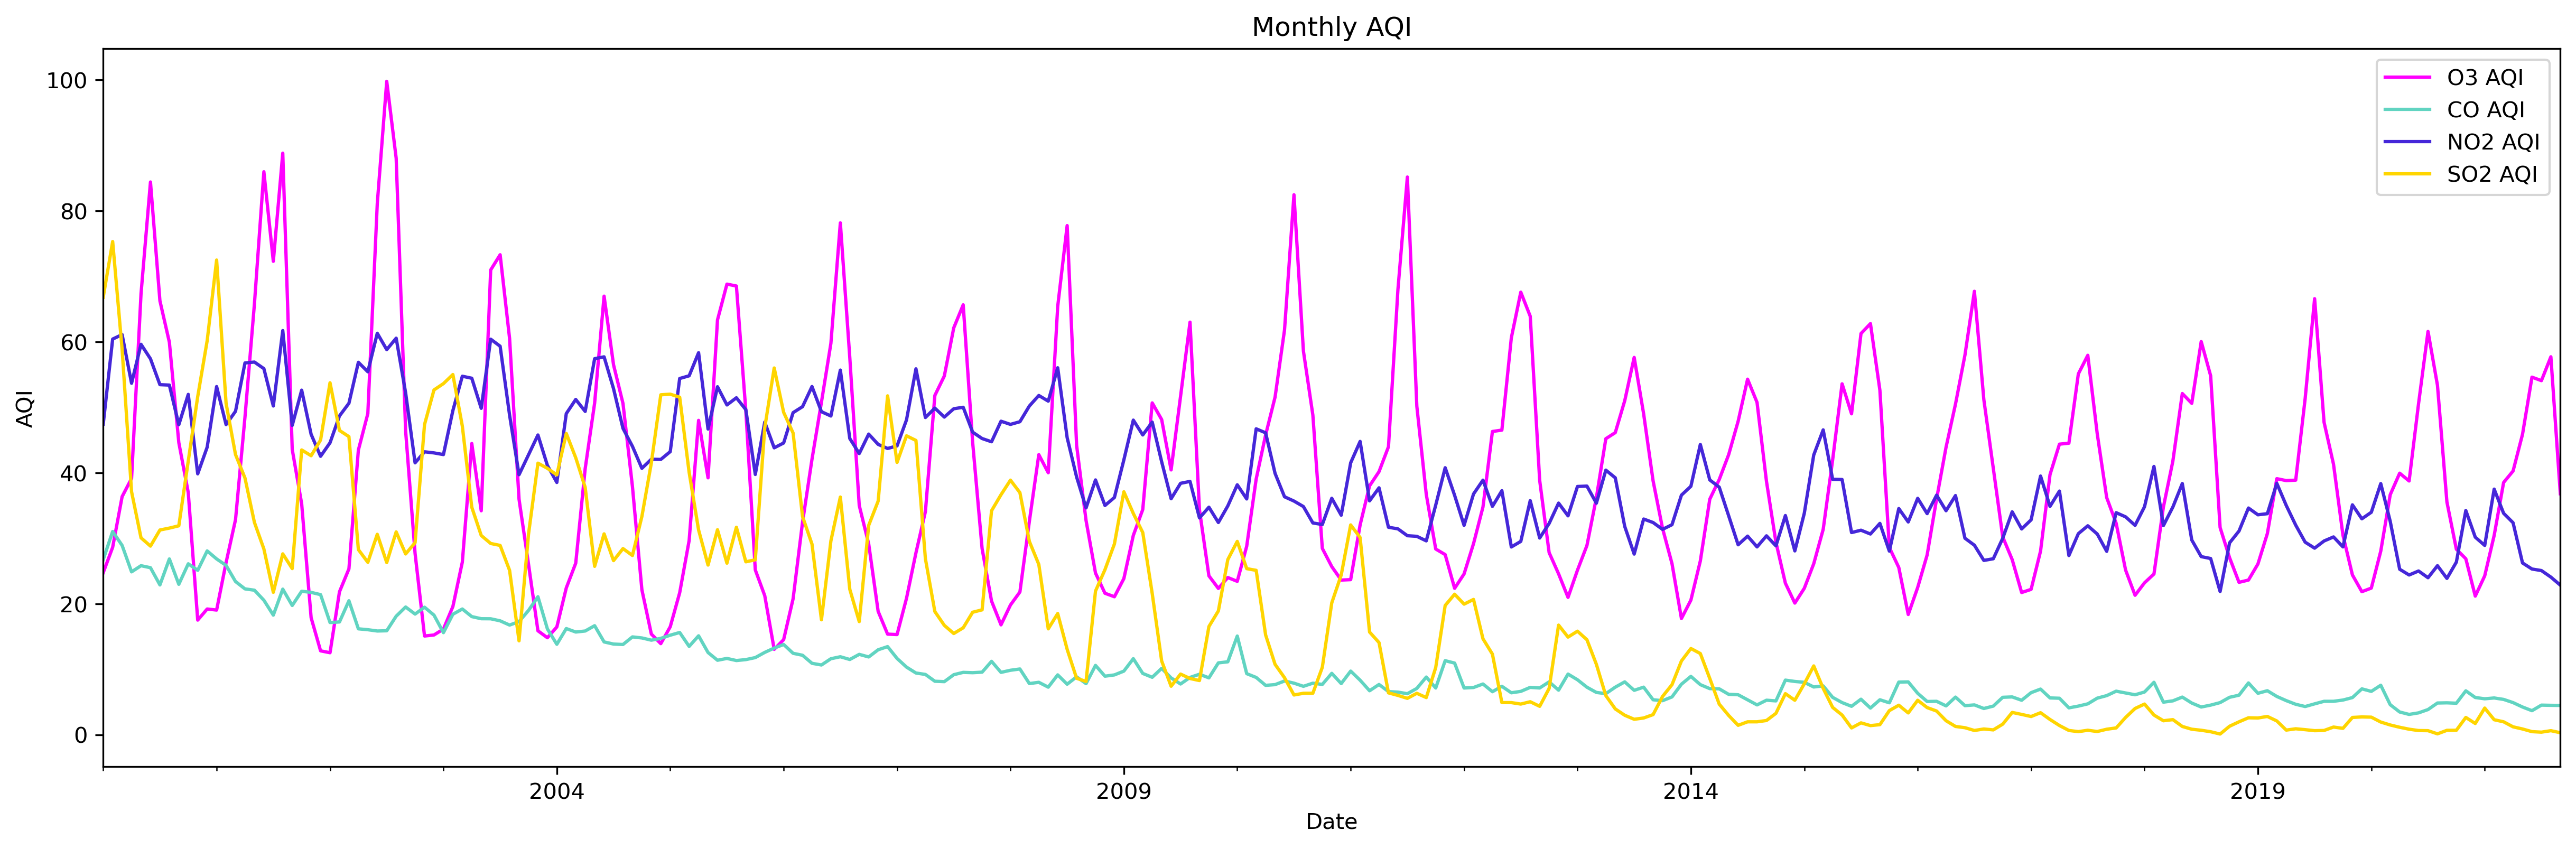

In [66]:
# Plotting monthly AQI
plt.figure(figsize=(20,6), dpi=300)
plot_monthlys[0].plot(color='magenta')
plot_monthlys[1].plot(color='#61d4c1')
plot_monthlys[2].plot(color='#4527d9')
plot_monthlys[3].plot(color='#ffd500')
plt.title('Monthly AQI')
plt.ylabel('AQI')
plt.legend();

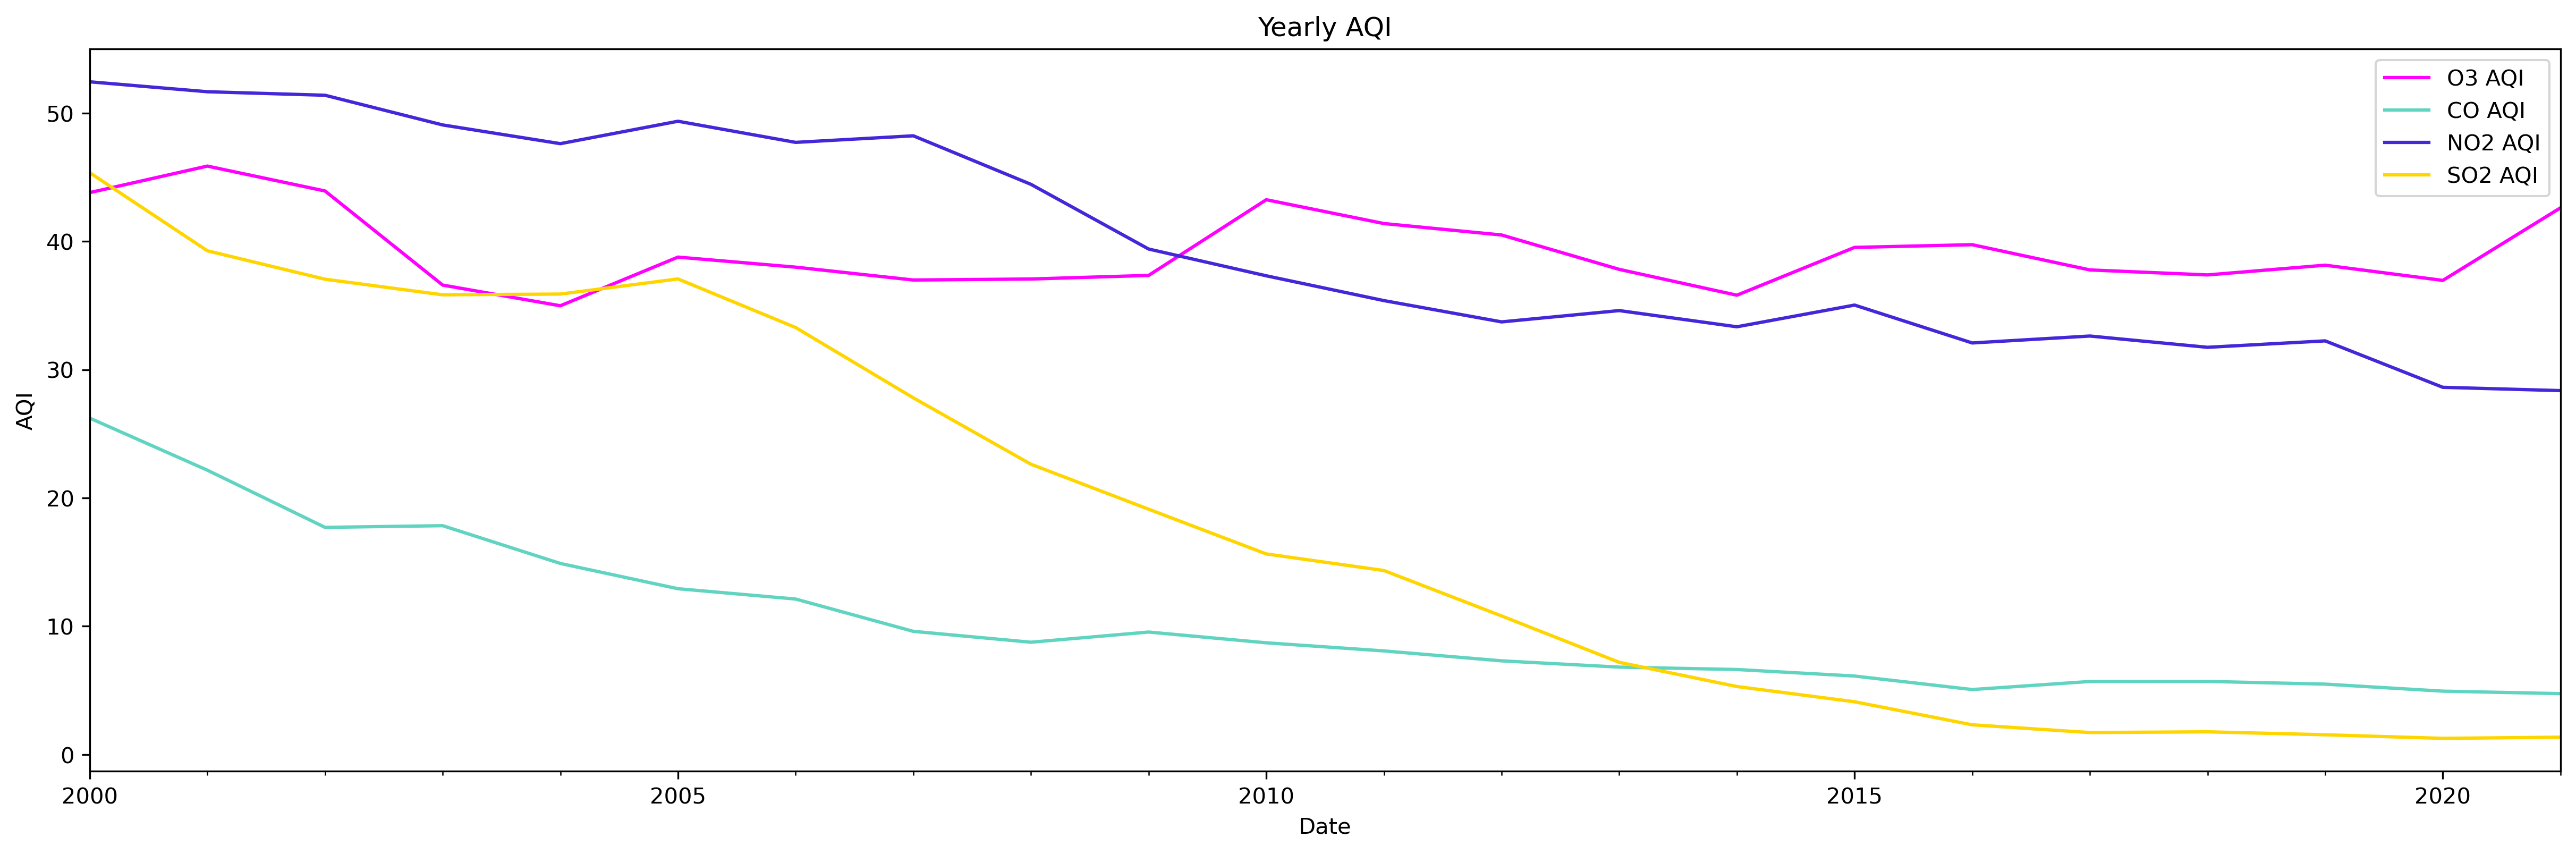

In [67]:
# Plotting yearly AQI
plt.figure(figsize=(20,6), dpi=300)
plot_yearlys[0].plot(color='magenta')
plot_yearlys[1].plot(color='#61d4c1')
plot_yearlys[2].plot(color='#4527d9')
plot_yearlys[3].plot(color='#ffd500')
plt.title('Yearly AQI')
plt.ylabel('AQI')
plt.legend();

Results of Dickey-Fuller Test (O3): 
 ---------------------------
Test Statistic           -6.420012e+00
p-value                   1.801269e-08
# of Lags Used            2.900000e+01
# of Observations Used    7.914000e+03
Critical Value (1%)      -3.431177e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


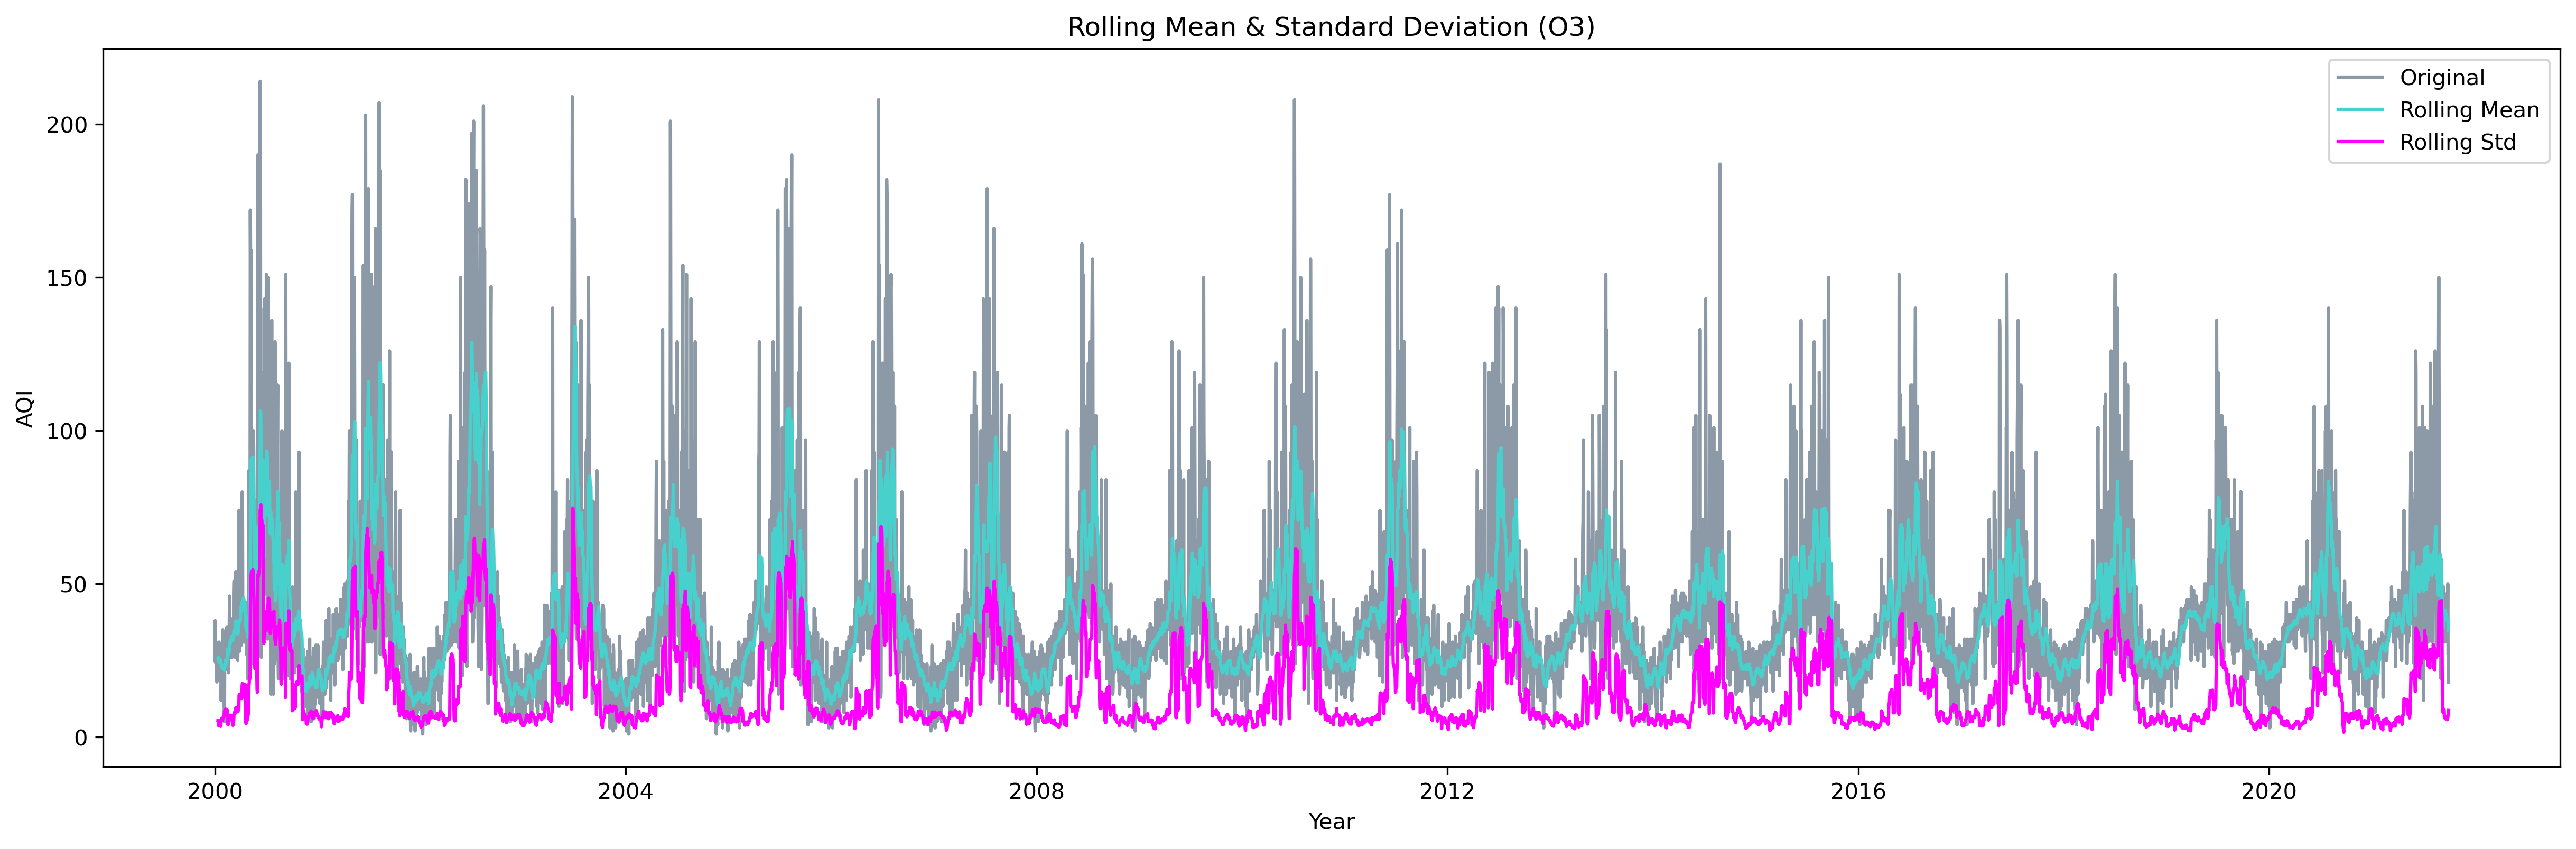

In [12]:
stationarity_check(dailyO3, 'Daily O3')

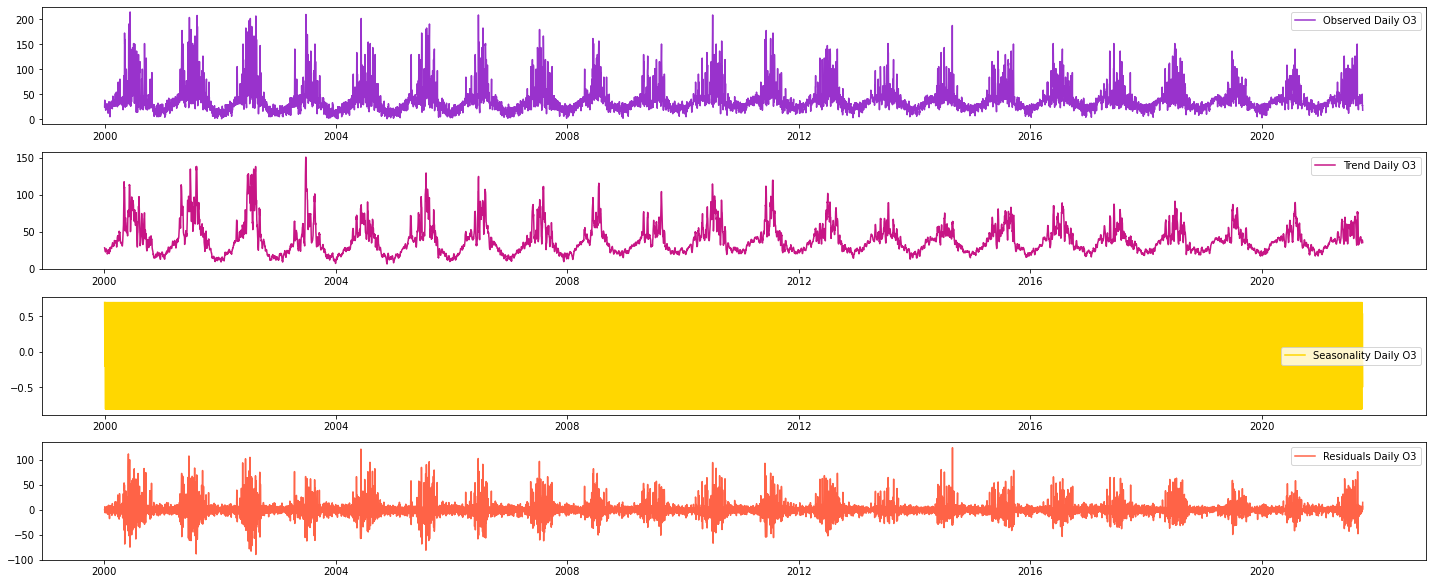

In [69]:
decomposition_plot(dailyO3, 'Daily O3')

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fbd31b69820>,
 Date
 2000-01-01         NaN
 2000-01-02         NaN
 2000-01-03         NaN
 2000-01-04    3.323645
 2000-01-05    3.276716
                 ...   
 2021-09-26    3.606148
 2021-09-27    3.515293
 2021-09-28         NaN
 2021-09-29         NaN
 2021-09-30         NaN
 Name: trend, Length: 7944, dtype: float64,
 Date
 2000-01-01    0.036151
 2000-01-02    0.052902
 2000-01-03   -0.008846
 2000-01-04   -0.006003
 2000-01-05   -0.021458
                 ...   
 2021-09-26    0.052902
 2021-09-27   -0.008846
 2021-09-28   -0.006003
 2021-09-29   -0.021458
 2021-09-30   -0.030224
 Name: seasonal, Length: 7944, dtype: float64,
 Date
 2000-01-01         NaN
 2000-01-02         NaN
 2000-01-03         NaN
 2000-01-04    0.049654
 2000-01-05   -0.077204
                 ...   
 2021-09-26   -0.021465
 2021-09-27    0.405576
 2021-09-28         NaN
 2021-09-29         NaN
 2021-09-30         NaN
 Name: resid, Length: 7944, dtype: f

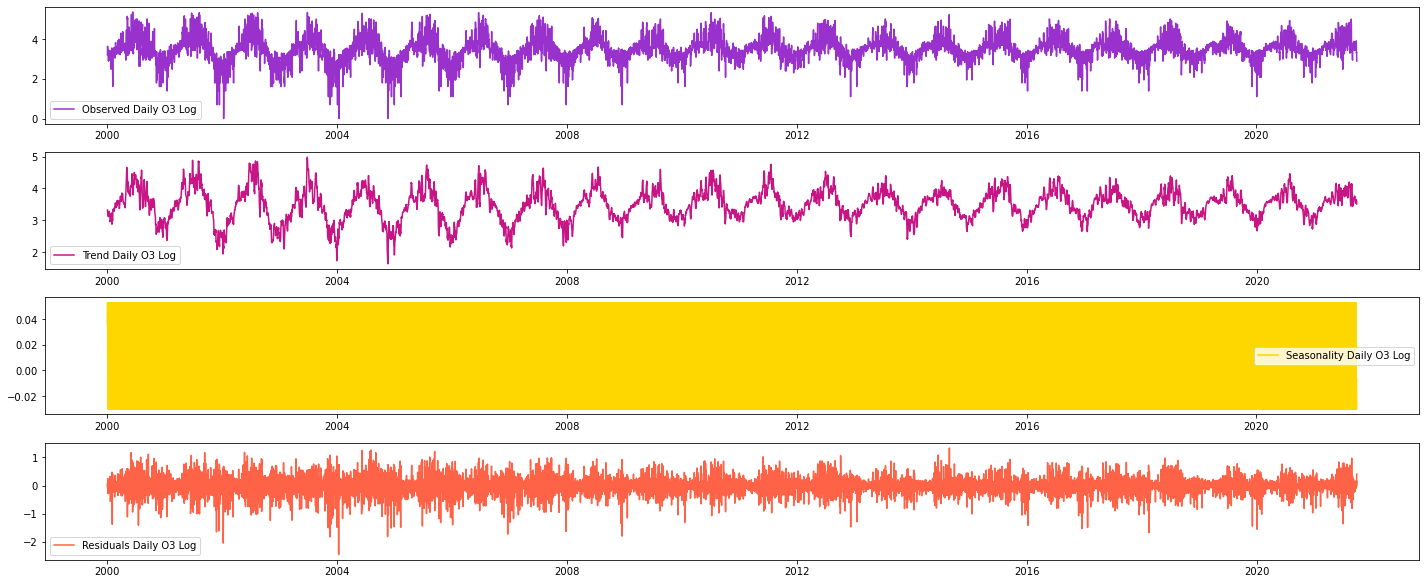

In [29]:
decomposition_plot(np.log(dailyO3), 'Daily O3 Log')

Results of Dickey-Fuller Test (dailyO3log_decomp): 
 ---------------------------
Test Statistic             -29.834035
p-value                      0.000000
# of Lags Used              36.000000
# of Observations Used    7901.000000
Critical Value (1%)         -3.431178
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


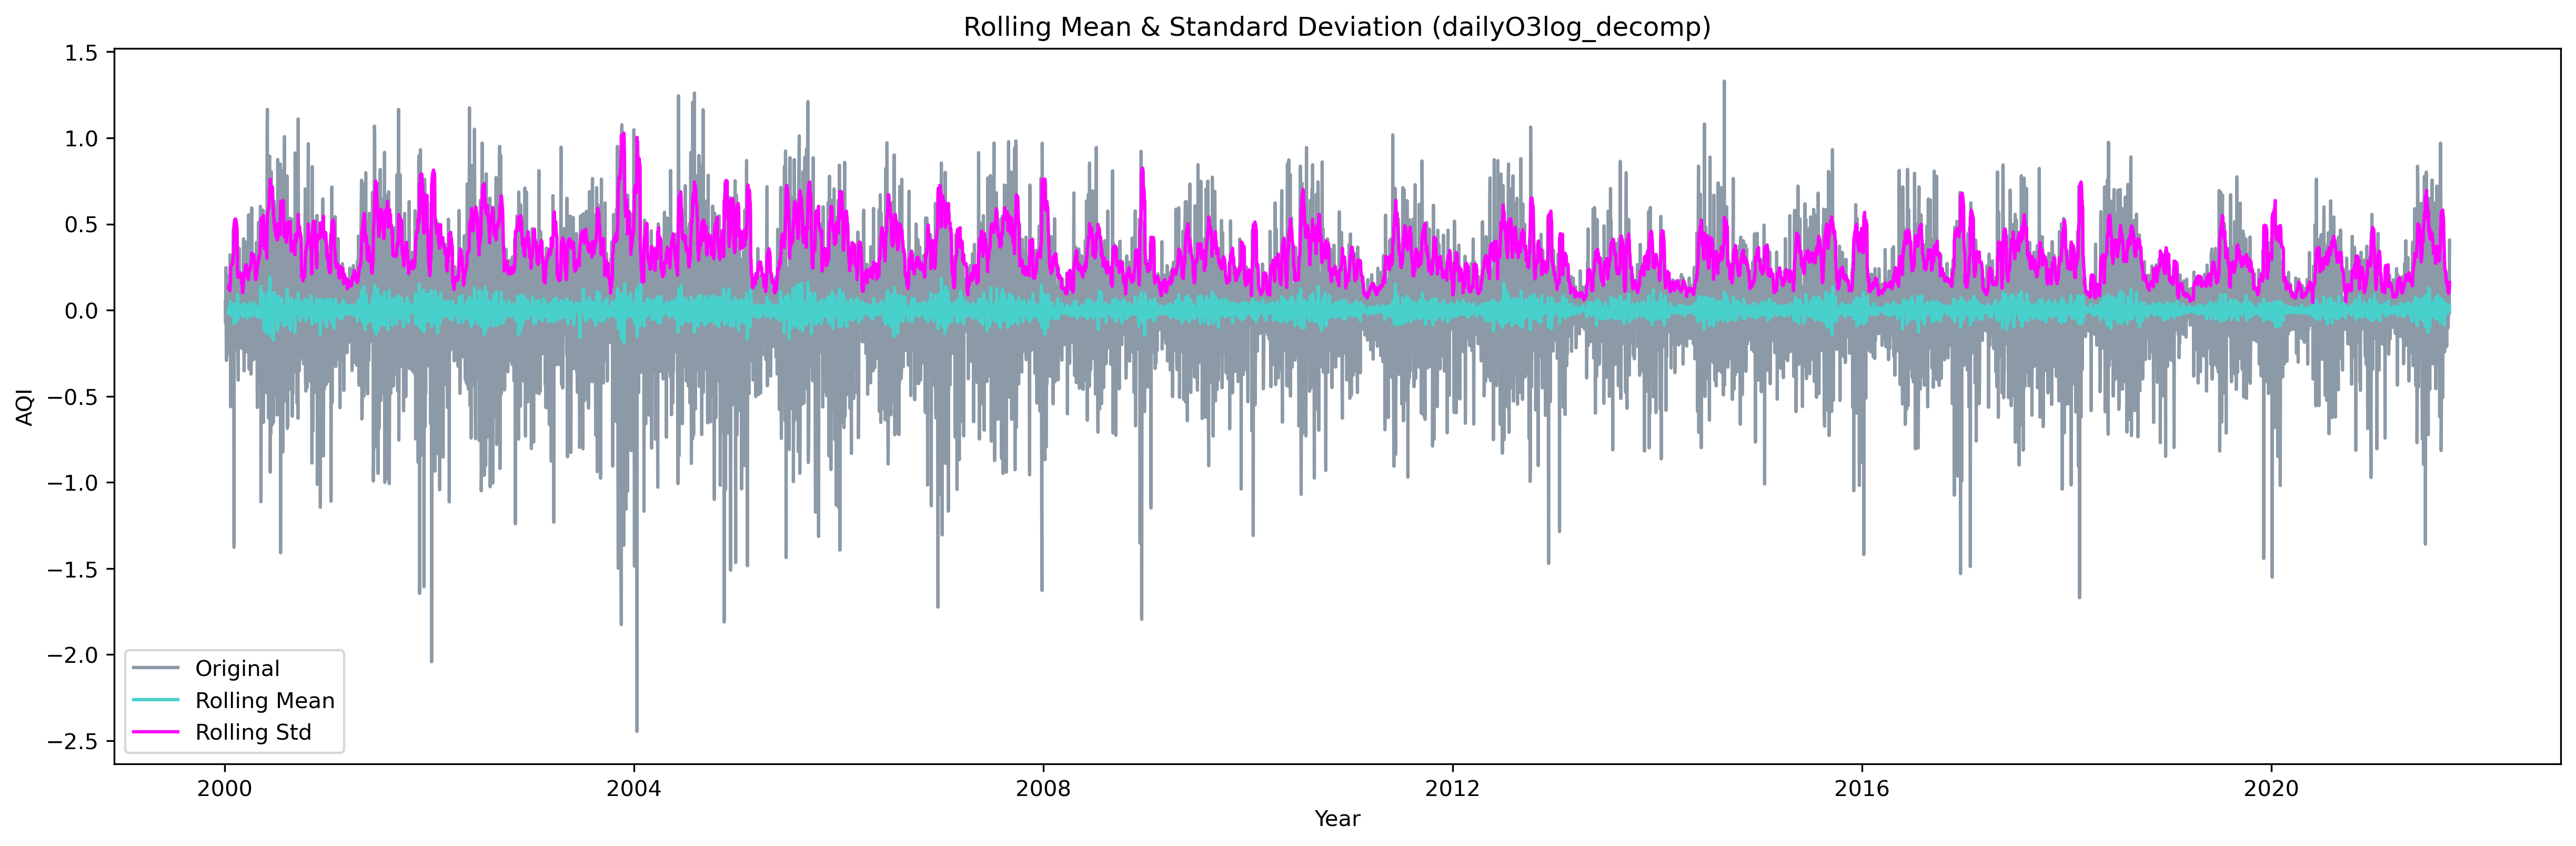

In [33]:
dailyO3log = np.log(dailyO3)

decomposition = seasonal_decompose(dailyO3log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

dailyO3log_decomp = residual
dailyO3log_decomp.dropna(inplace=True)

stationarity_check(dailyO3log_decomp, 'dailyO3log_decomp')

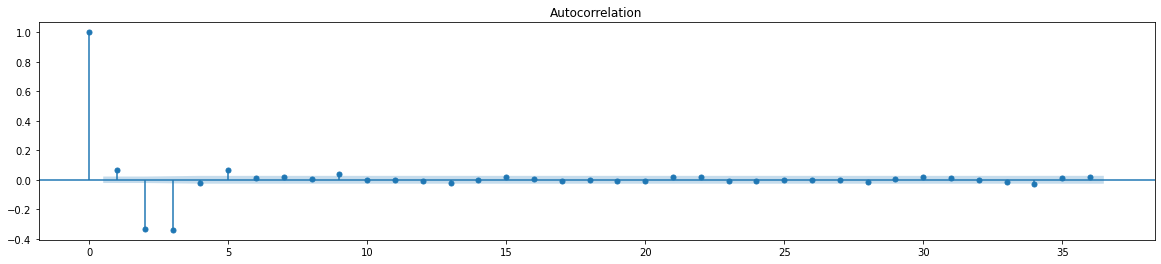

In [41]:
fig, ax = plt.subplots(figsize=(20,4))
plot_acf(dailyO3log_decomp, ax=ax, lags=36)

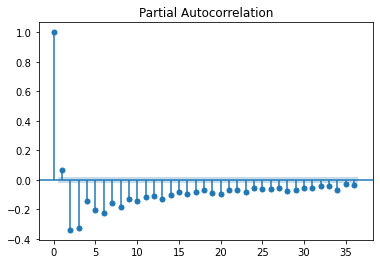

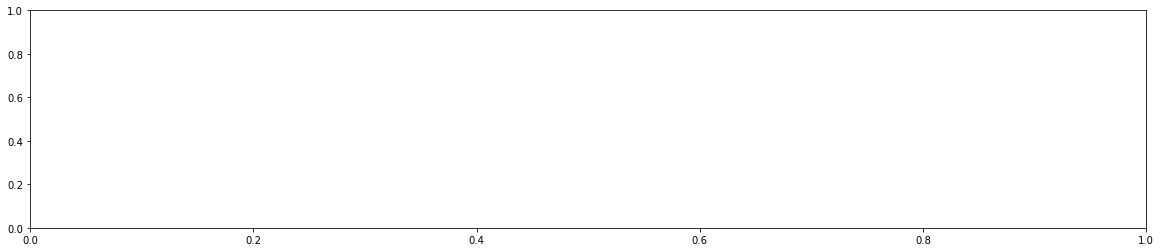

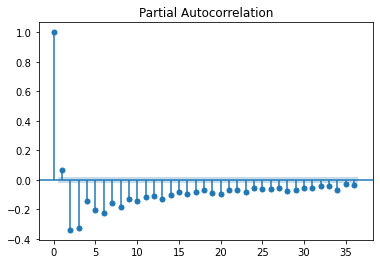

In [43]:
fig, ax = plt.subplots(figsize=(20,4))
plot_pacf(dailyO3log_decomp, lags=36)

In [44]:
dailyO3log_decomp

Date
2000-01-04    0.049654
2000-01-05   -0.077204
2000-01-06    0.247310
2000-01-07   -0.149653
2000-01-08   -0.292485
                ...   
2021-09-23   -0.033552
2021-09-24    0.061907
2021-09-25    0.188772
2021-09-26   -0.021465
2021-09-27    0.405576
Name: resid, Length: 7938, dtype: float64

In [47]:
mod_arma = ARMA(dailyO3, order=(1,0), freq='D')
res_arma = mod_arma.fit()
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 O3 AQI   No. Observations:                 7944
Model:                     ARMA(1, 0)   Log Likelihood              -35186.832
Method:                       css-mle   S.D. of innovations             20.295
Date:                Thu, 27 Jan 2022   AIC                          70379.665
Time:                        22:19:33   BIC                          70400.605
Sample:                    01-01-2000   HQIC                         70386.835
                         - 09-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.2405      0.670     58.606      0.000      37.928      40.553
ar.L1.O3 AQI     0.6600      0.008     78.314      0.000       0.643       0.677
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5152           +0.0000j            1.5152            0.0000
-----------------------------------------------------------------------------
"""

In [48]:
res_arma.predict()

2000-01-01    39.240461
2000-01-02    29.841758
2000-01-03    38.421757
2000-01-04    33.801757
2000-01-05    32.481758
                ...    
2021-09-26    44.361756
2021-09-27    38.421757
2021-09-28    46.341756
2021-09-29    31.161758
2021-09-30    31.821758
Freq: D, Length: 7944, dtype: float64

> I decided to make additional dataframes for modeling average monthly `AQI` and one that combined all four pollutant dataframes into one, simply named `df`, for visualization purposes.

> I check stationarity of all the daily data. I run the function for each pollutant in their own cell because it's easier to see than when I tried to run them all through a for loop.
>
> But if you prefer a for loop:
> ```
> dfstr = ['O3', 'CO', 'NO2', 'SO2']
> i=0
> for df in dailys:
>     stationarity_check(df, dfstr[i])
>     i+=1
> ```

In [ ]:
stationarity_check(dailyO3, 'O3')

In [ ]:
stationarity_check(dailyCO, 'CO')

In [ ]:
stationarity_check(dailyNO2, 'NO2')

In [ ]:
stationarity_check(dailySO2, 'SO2')

> My stationarity check shows all pollutants are stationary when using daily `AQI` values. However, there is still seasonality that I want to try eliminating for ARIMA modeling.

# Monthly O3 + ARIMA

Results of Dickey-Fuller Test (monthly o3): 
 ---------------------------
Test Statistic             -2.691106
p-value                     0.075590
# of Lags Used             11.000000
# of Observations Used    249.000000
Critical Value (1%)        -3.456888
Critical Value (5%)        -2.873219
Critical Value (10%)       -2.572994
dtype: float64


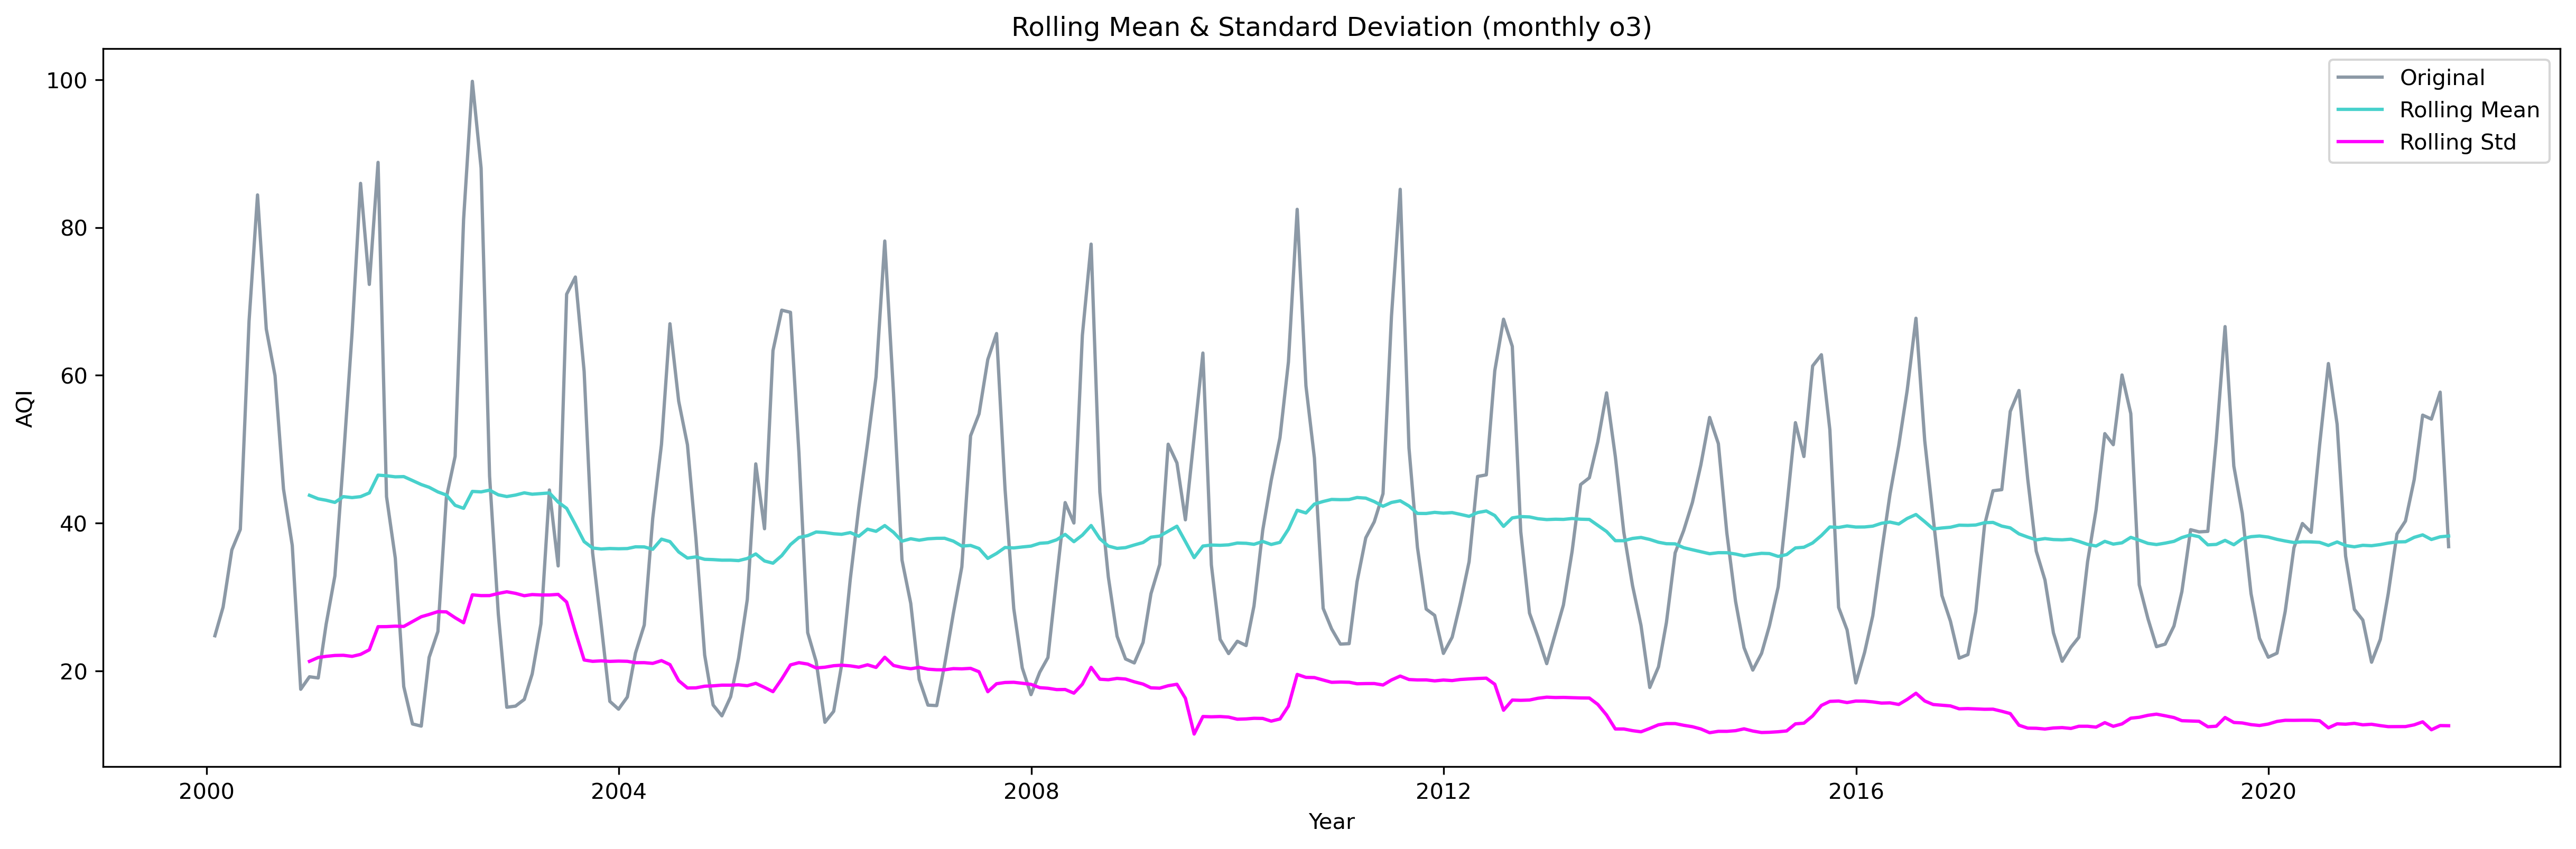

In [12]:
stationarity_check(monthlyO3, 'monthly o3')

> Monthly O3 is not stationary.

In [ ]:
monthlyO3_log = np.log(monthlyO3)

In [ ]:
# Eliminating trend and seasonality with first order differencing 
dailyO3_diff = dailyO3 - dailyO3.shift()
dailyO3_diff.plot(figsize=(22,2), title='Daily O3 Differenced')
dailyO3_diff.dropna(inplace=True)
stationarity_check(dailyO3_diff, 'O3')

In [ ]:
# Eliminating trend and seasonality with first order differencing 
dailyO3_diff = dailyO3 - dailyO3.shift()
dailyO3_diff.plot(figsize=(22,2), title='Daily O3 Differenced')
dailyO3_diff.dropna(inplace=True)
stationarity_check(dailyO3_diff, 'O3')

In [54]:
def train_test_split(df, ratio=0.85):
    train_size = int(len(df) * ratio)
    train, test = df[0:train_size], df[train_size:]
    return train, test

In [55]:
dailyO3_train, dailyO3_test = train_test_split(dailyO3)

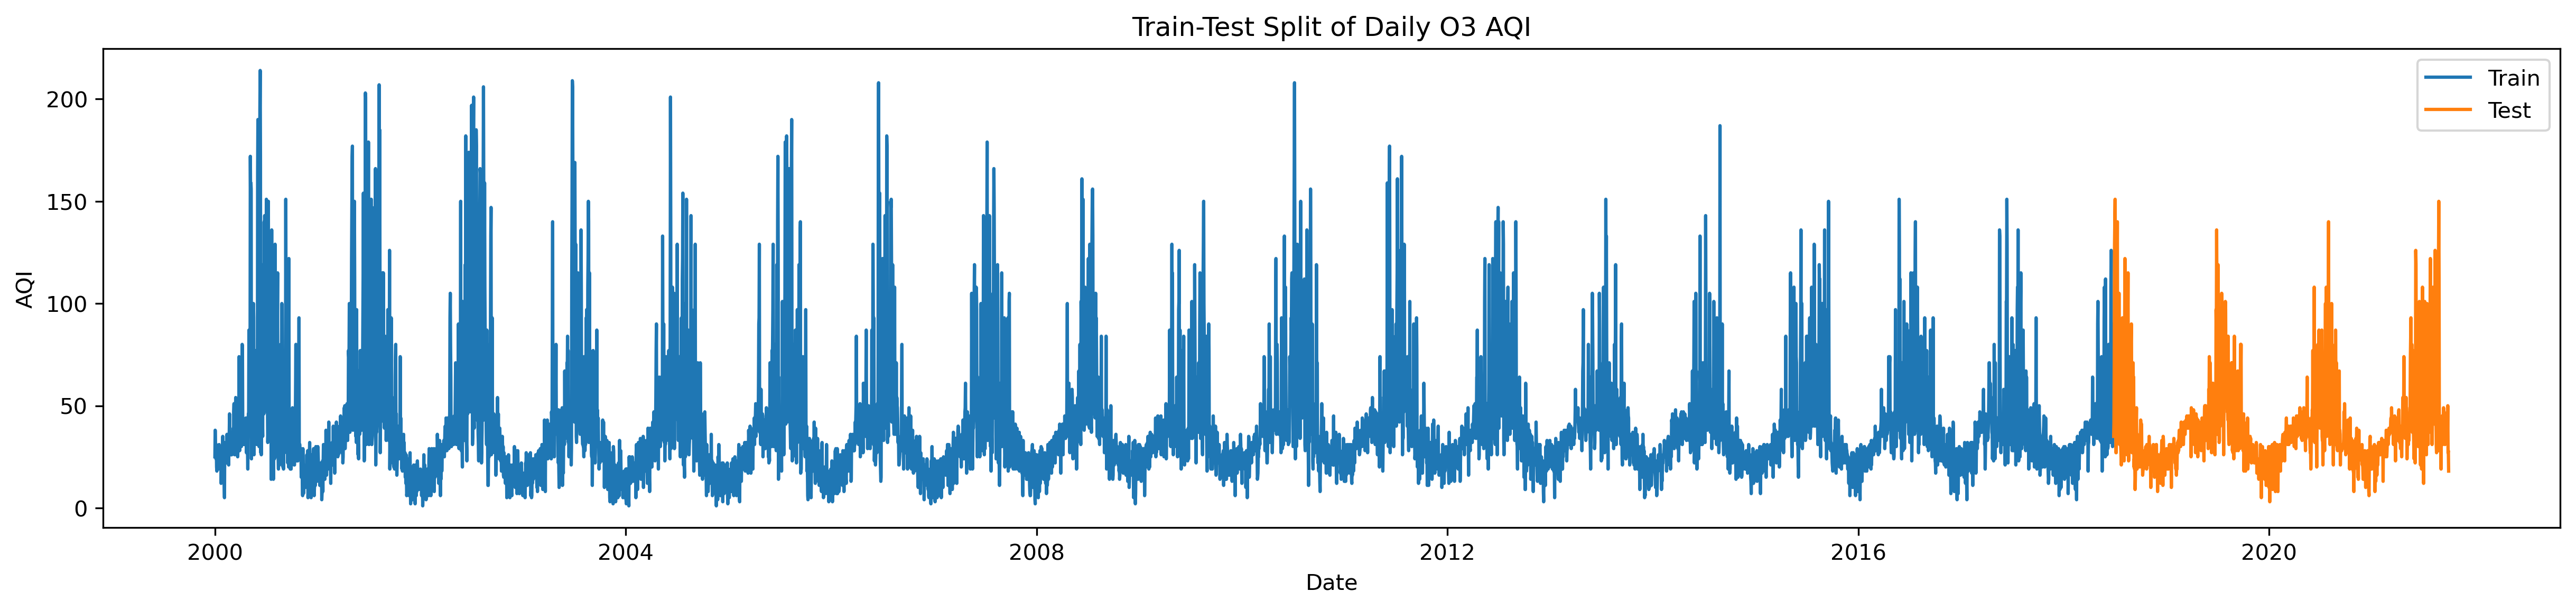

In [57]:
fig, ax = plt.subplots(figsize=(20,4), dpi=300)
ax.plot(dailyO3_train, label='Train')
ax.plot(dailyO3_test, label='Test')
ax.set_title('Train-Test Split of Daily O3 AQI');
ax.set_xlabel('Year')
ax.set_ylabel('AQI')
plt.legend();

Results of Dickey-Fuller Test (daily CO): 
 ---------------------------
Test Statistic              -3.077750
p-value                      0.028244
# of Lags Used              36.000000
# of Observations Used    7908.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


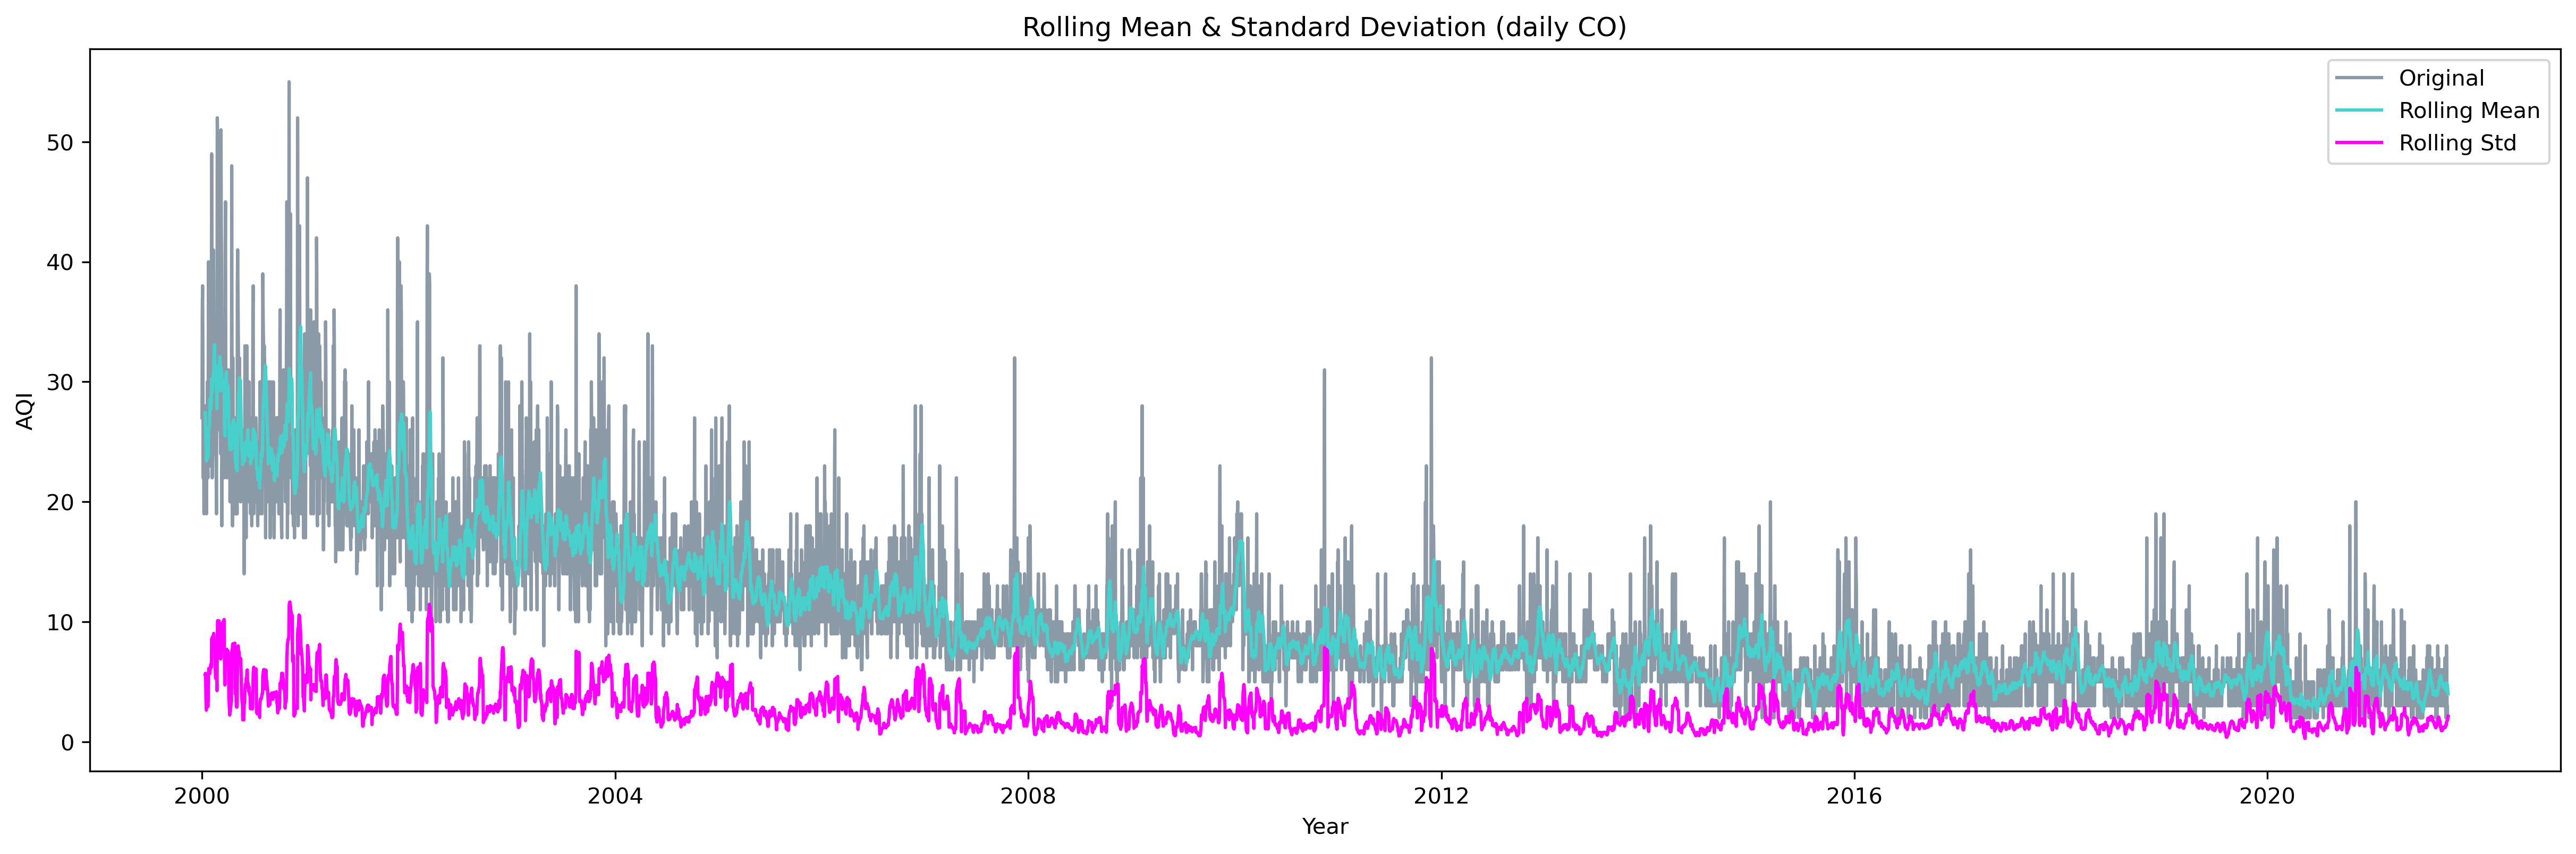

In [60]:
stationarity_check(dailyCO, 'daily CO')

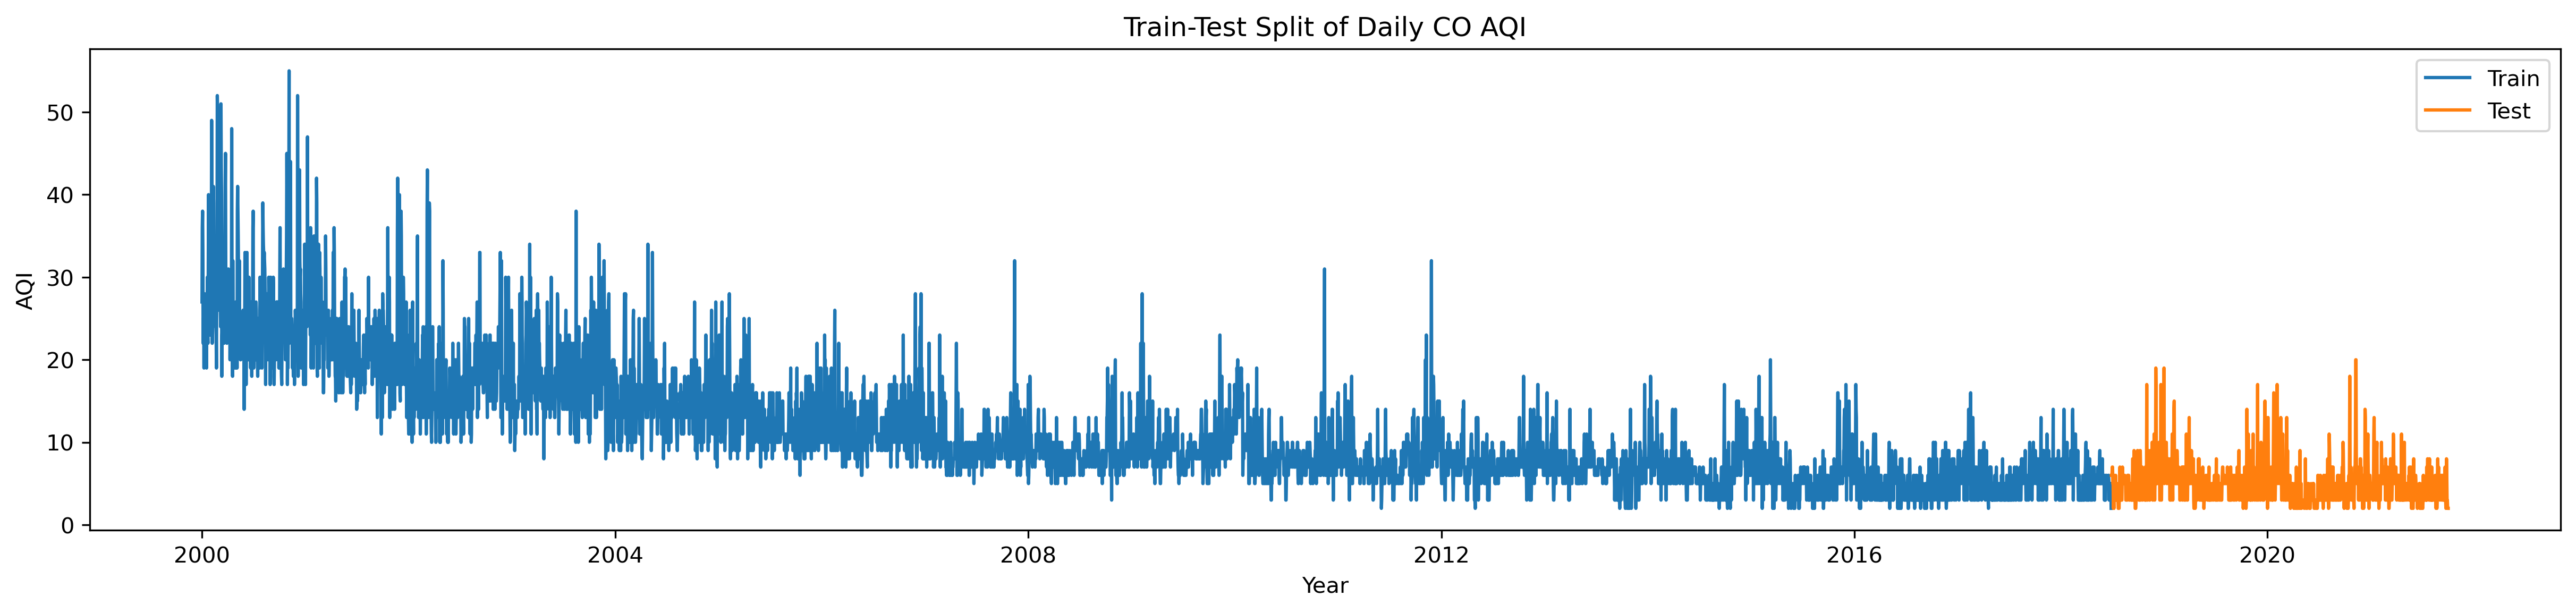

In [58]:
dailyCO_train, dailyCO_test = train_test_split(dailyCO)

fig, ax = plt.subplots(figsize=(20,4), dpi=300)
ax.plot(dailyCO_train, label='Train')
ax.plot(dailyCO_test, label='Test')
ax.set_title('Train-Test Split of Daily CO AQI');
ax.set_xlabel('Year')
ax.set_ylabel('AQI')
plt.legend();

In [ ]:

# split into train and test sets
X = dailyO3.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mse(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Eliminating trend and seasonality with first order differencing 
dailyCO_diff = dailyCO - dailyCO.shift()
dailyCO_diff.plot(figsize=(22,2), title='Daily CO Differenced')
dailyCO_diff.dropna(inplace=True)
stationarity_check(dailyCO_diff, 'CO')

In [ ]:
# Eliminating trend and seasonality with first order differencing 
dailyNO2_diff = dailyNO2 - dailyNO2.shift()
dailyNO2_diff.plot(figsize=(22,2), title='Daily NO2 Differenced')
dailyNO2_diff.dropna(inplace=True)
stationarity_check(dailyNO2_diff, 'NO2')

In [ ]:
# Eliminating trend and seasonality with first order differencing 
dailySO2_diff = dailyCO - dailyCO.shift()
dailySO2_diff.plot(figsize=(22,2), title='Daily SO2 Differenced')
dailySO2_diff.dropna(inplace=True)
stationarity_check(dailySO2_diff, 'SO2')

In [ ]:
# Daily AQI log
dailyO3_log = np.log(O3)
dailyCO_log = np.log(CO)
dailyNO2_log = np.log(NO2)
dailySO2_log = np.log(SO2)

daily_log = [dailyO3_log, dailyCO_log, dailyNO2_log, dailySO2_log]

In [ ]:
for df in daily_log:
    df.plot(figsize=(20,2), color='teal')

In [ ]:
# Checking daily O3
dailyO3_log.plot(figsize=(20,2))
stationarity_check(dailyO3_log, 'O3')

In [13]:
# Monthly AQI log
monthlyO3_log = np.log(monthlyO3)
monthlyCO_log = np.log(monthlyCO)
monthlyNO2_log = np.log(monthlyNO2)
monthlySO2_log = np.log(monthlySO2)

Results of Dickey-Fuller Test (O3): 
 ---------------------------
Test Statistic             -2.153275
p-value                     0.223639
# of Lags Used             15.000000
# of Observations Used    245.000000
Critical Value (1%)        -3.457326
Critical Value (5%)        -2.873410
Critical Value (10%)       -2.573096
dtype: float64


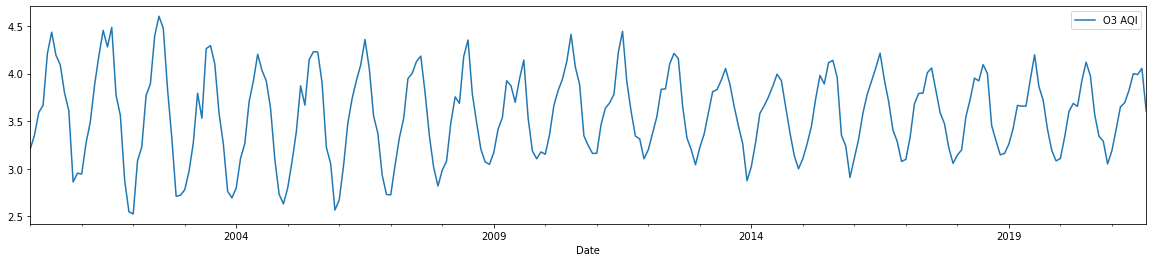

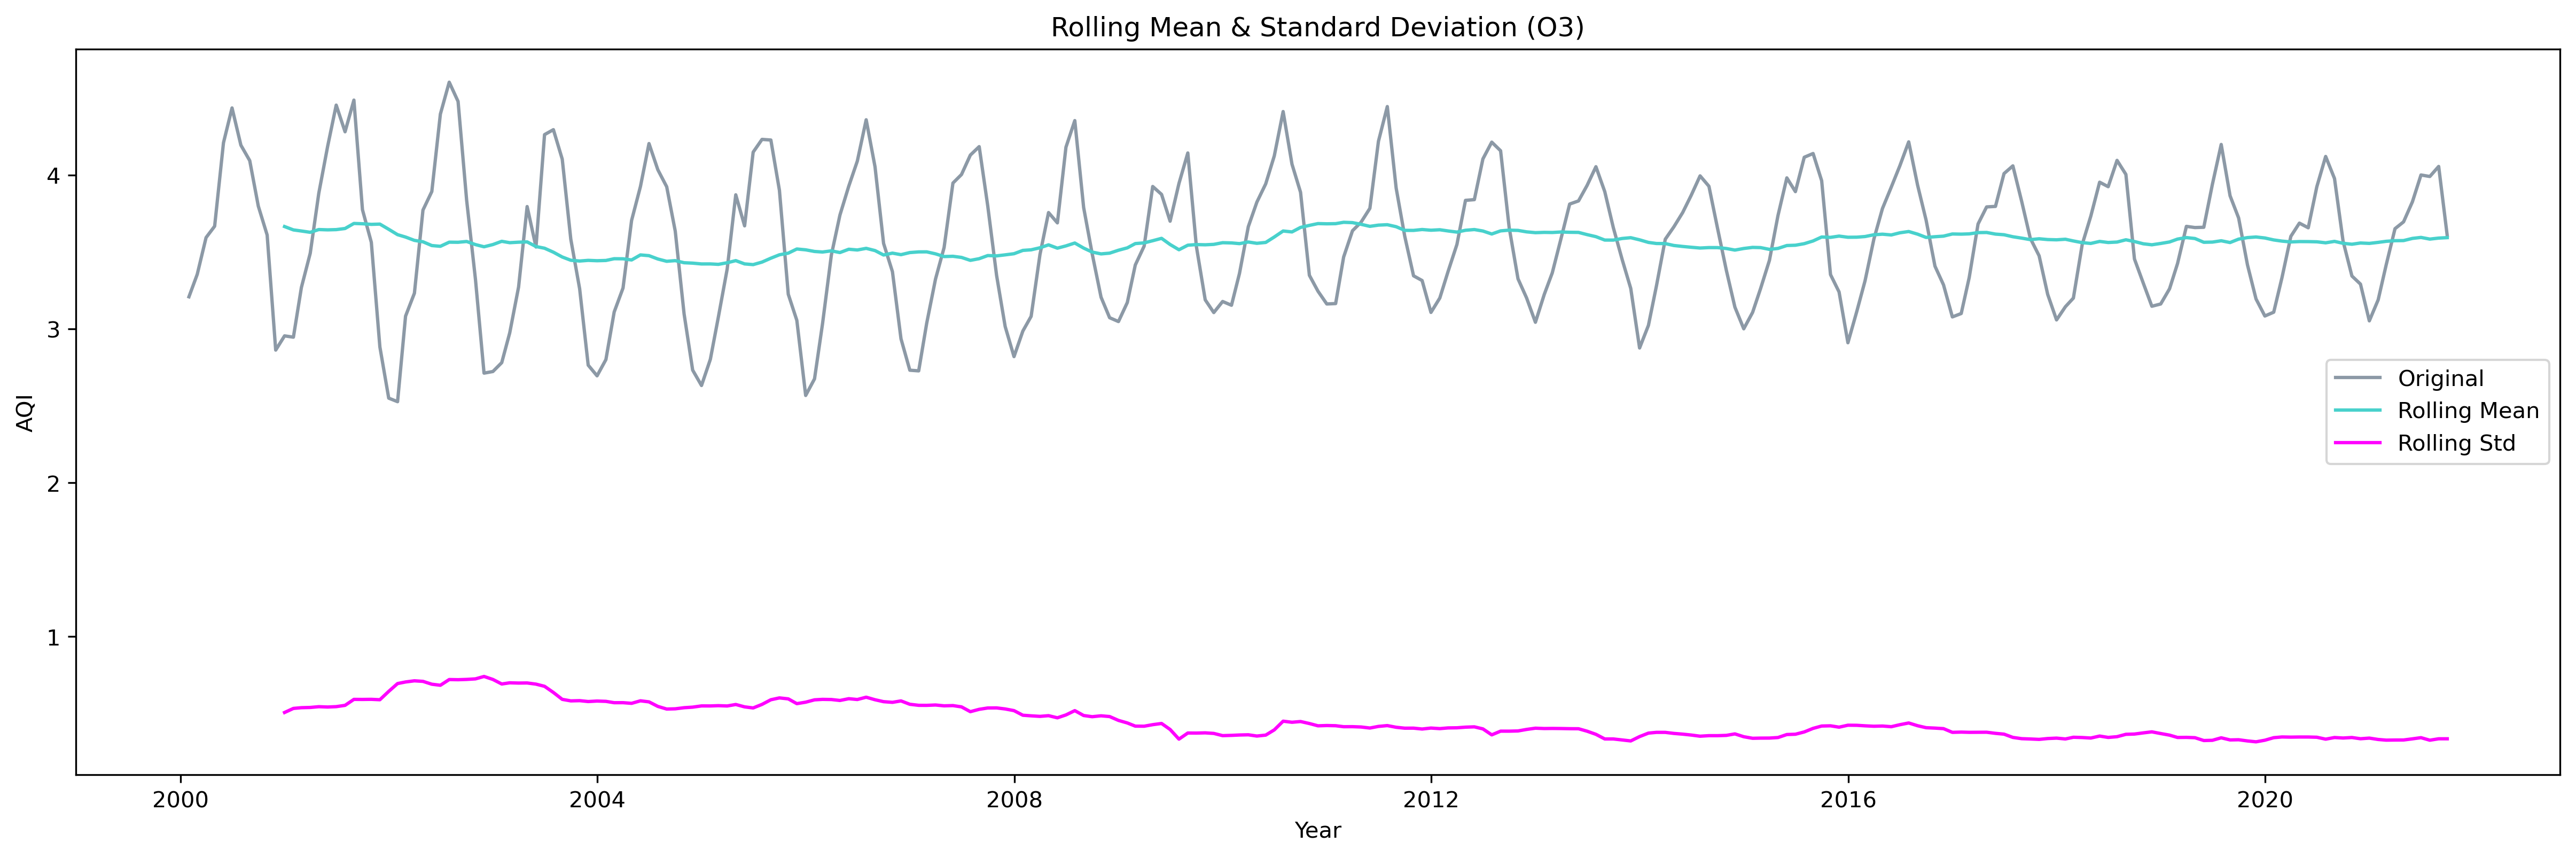

In [14]:
# Checking monthly O3
monthlyO3_log.plot(figsize=(20,4))
stationarity_check(monthlyO3_log, 'O3')

Results of Dickey-Fuller Test (O3): 
 ---------------------------
Test Statistic             -4.894367
p-value                     0.000036
# of Lags Used             14.000000
# of Observations Used    235.000000
Critical Value (1%)        -3.458487
Critical Value (5%)        -2.873919
Critical Value (10%)       -2.573367
dtype: float64


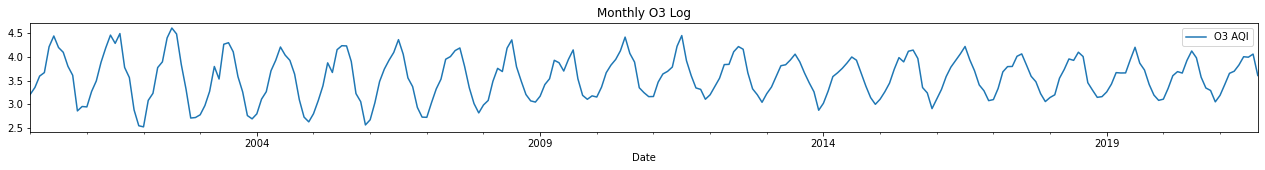

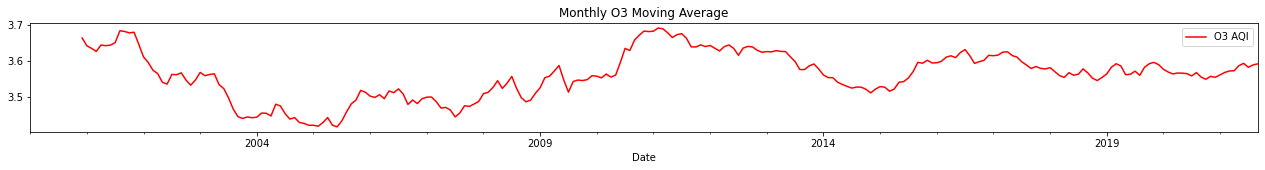

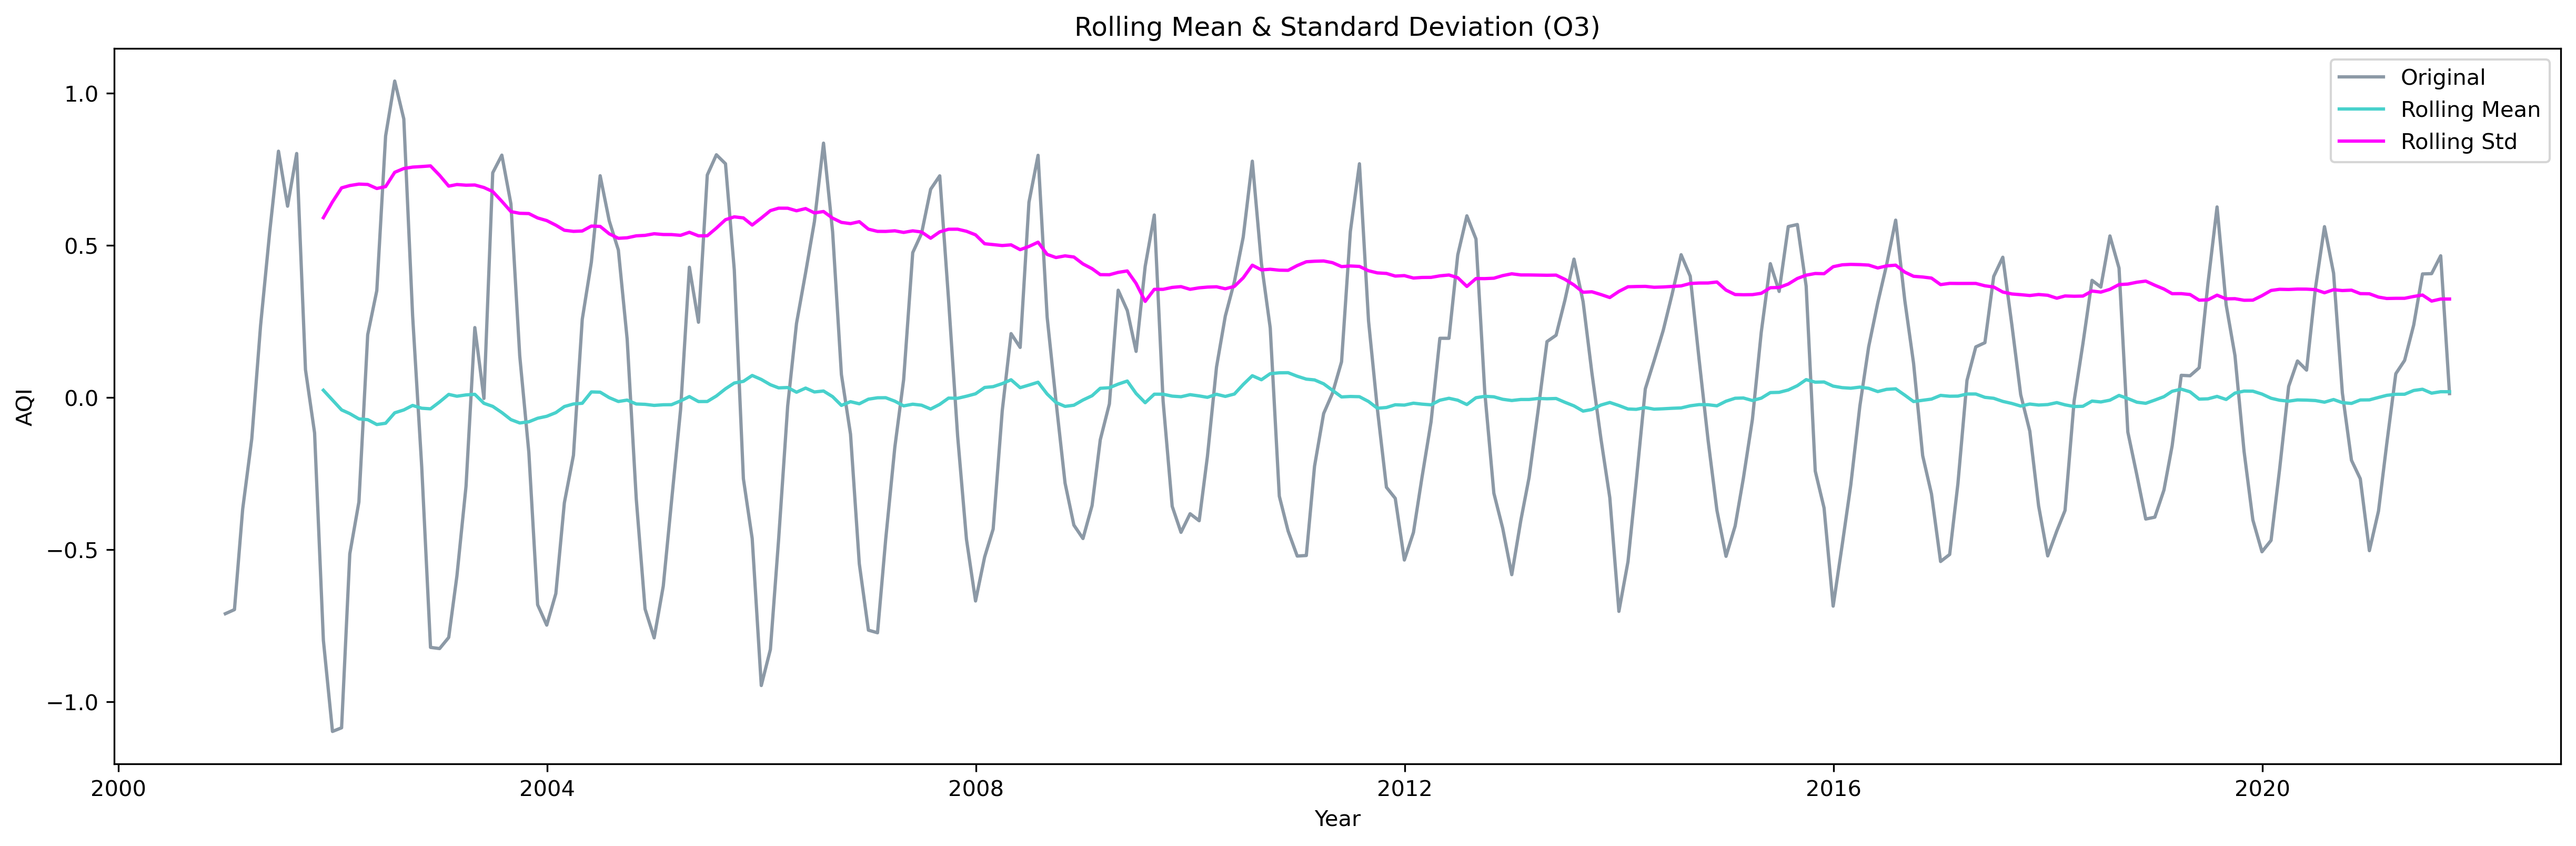

In [15]:
# Moving average O3
moving_avg = monthlyO3_log.rolling(window=12).mean()
monthlyO3_log.plot(figsize=(22,2), title='Monthly O3 Log')
moving_avg.plot(figsize=(22,2), color='red', title='Monthly O3 Moving Average')
monthlyO3_log_moving_avg_diff = monthlyO3_log - moving_avg
monthlyO3_log_moving_avg_diff.dropna(inplace=True)

stationarity_check(monthlyO3_log_moving_avg_diff, 'O3')

Results of Dickey-Fuller Test (O3): 
 ---------------------------
Test Statistic           -7.267124e+00
p-value                   1.624025e-10
# of Lags Used            1.400000e+01
# of Observations Used    2.450000e+02
Critical Value (1%)      -3.457326e+00
Critical Value (5%)      -2.873410e+00
Critical Value (10%)     -2.573096e+00
dtype: float64


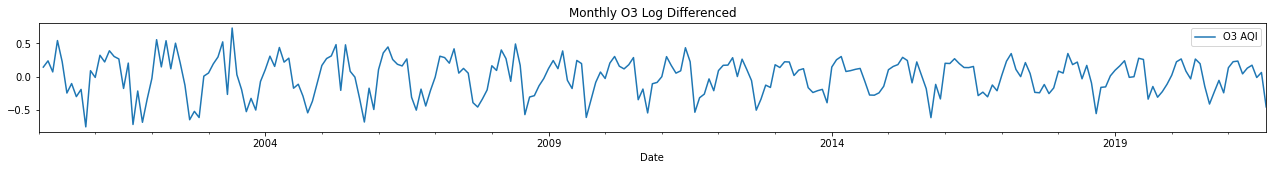

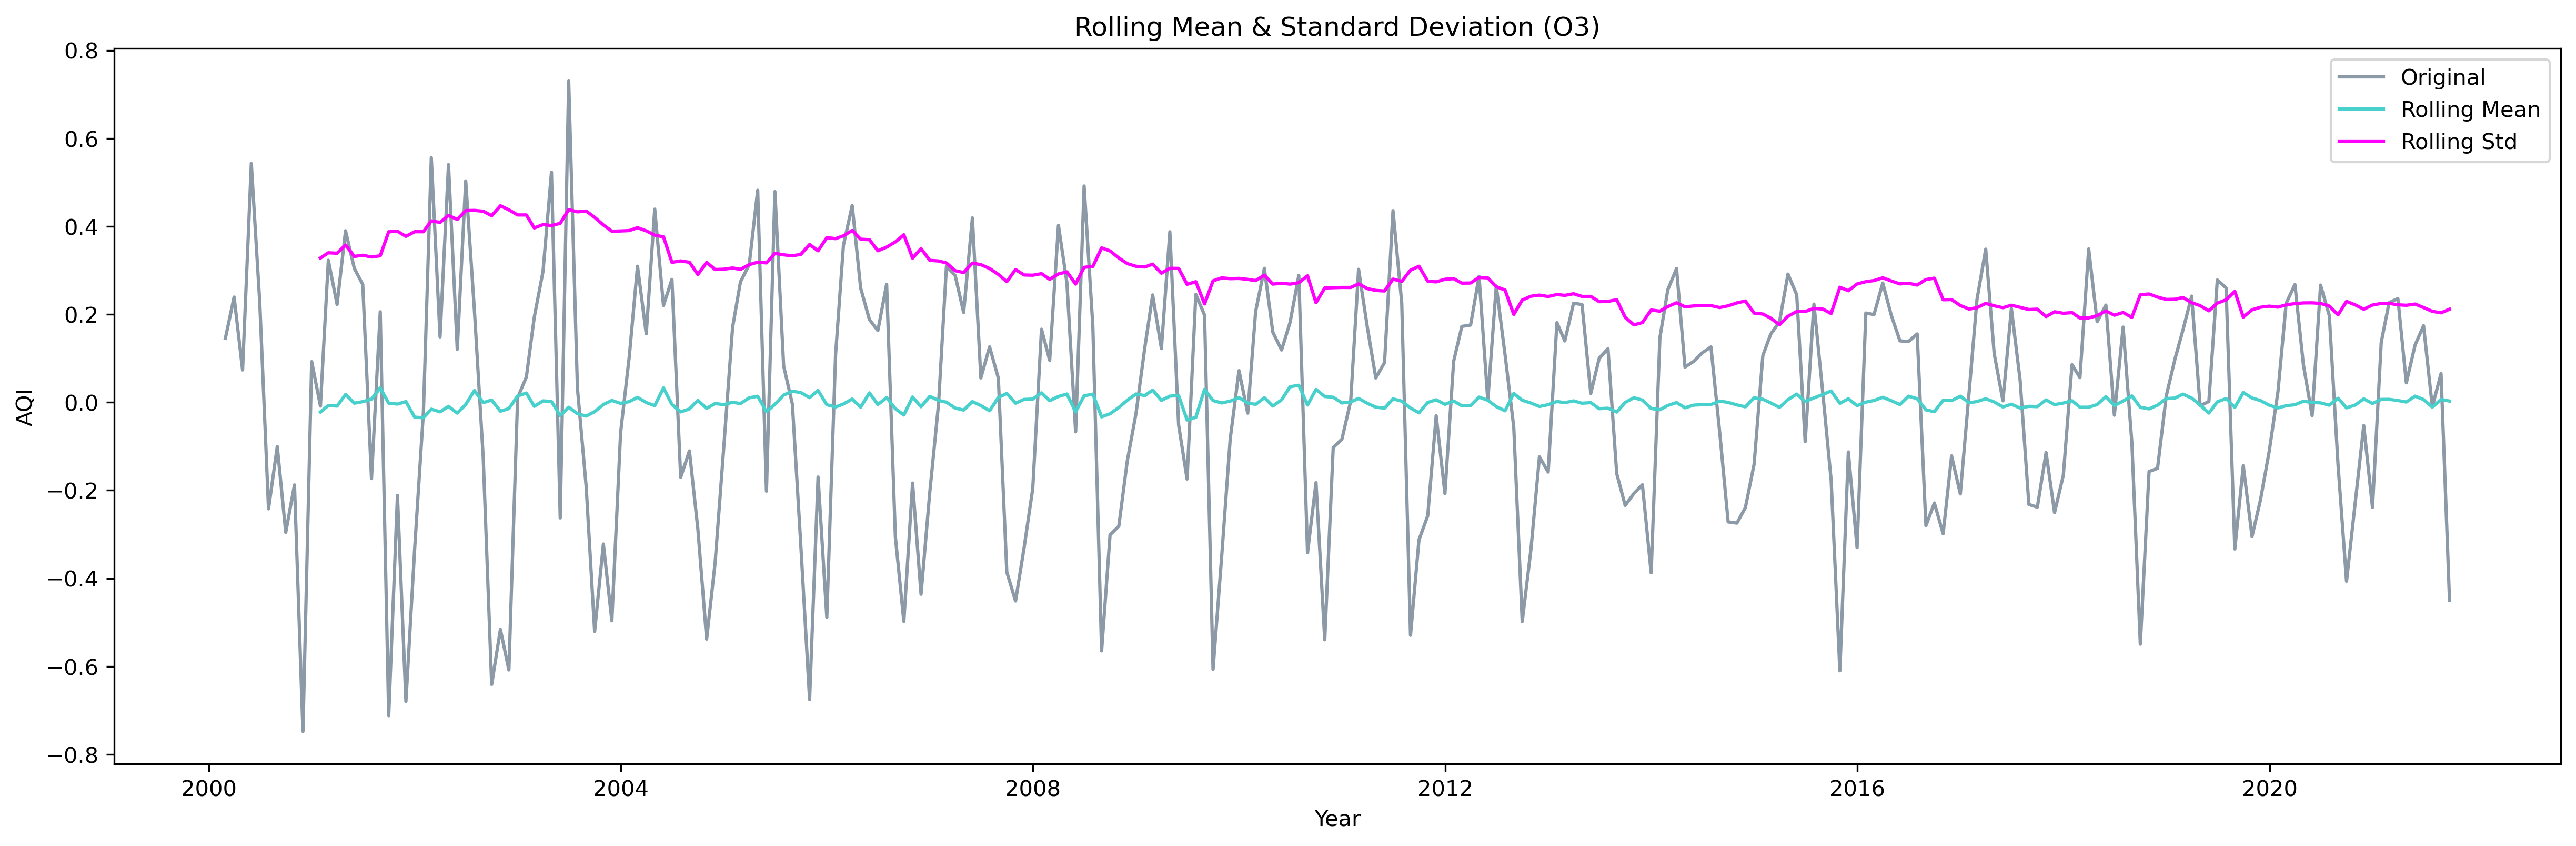

In [16]:
# Eliminating trend and seasonality
# First order differencing 
monthlyO3_log_diff = monthlyO3_log - monthlyO3_log.shift()
monthlyO3_log_diff.plot(figsize=(22,2), title='Monthly O3 Log Differenced')
monthlyO3_log_diff.dropna(inplace=True)
stationarity_check(monthlyO3_log_diff, 'O3')

In [17]:
# ACF and PACF for monthly O3 log diff
lag_acf = acf(monthlyO3_log_diff, nlags=20)
lag_pacf = pacf(monthlyO3_log_diff, nlags=20)

#Plot ACF & PACF
plt.figure(figsize=(20,4))
plt.plot(lag_acf), plt.plot(lag_pacf)
plt.legend(['Lag ACF', 'Lag PACF']);

In [18]:
# ACF and PACF for monthly O3 log moving avg diff
lag_acf = acf(monthlyO3_log_moving_avg_diff, nlags=20)
lag_pacf = pacf(monthlyO3_log_moving_avg_diff, nlags=20)

#Plot ACF & PACF
plt.figure(figsize=(20,4))
plt.plot(lag_acf), plt.plot(lag_pacf)
plt.legend(['Lag ACF', 'Lag PACF']);

In [ ]:

# Checking monthly CO
monthlyCO_log.plot(figsize=(20,4))
stationarity_check(monthlyCO_log, 'CO')

# Moving average CO
moving_avg = monthlyCO_log.rolling(window=12).mean()
monthlyCO_log.plot(figsize=(22,2), title='Monthly CO Log')
moving_avg.plot(figsize=(22,2), color='red', title='Monthly O3 Moving Average')
monthlyCO_log_moving_avg_diff = monthlyCO_log - moving_avg
monthlyCO_log_moving_avg_diff.dropna(inplace=True)

stationarity_check(monthlyCO_log_moving_avg_diff, 'CO')

Results of Dickey-Fuller Test (O3): 
 ---------------------------
Test Statistic           -7.267124e+00
p-value                   1.624025e-10
# of Lags Used            1.400000e+01
# of Observations Used    2.450000e+02
Critical Value (1%)      -3.457326e+00
Critical Value (5%)      -2.873410e+00
Critical Value (10%)     -2.573096e+00
dtype: float64


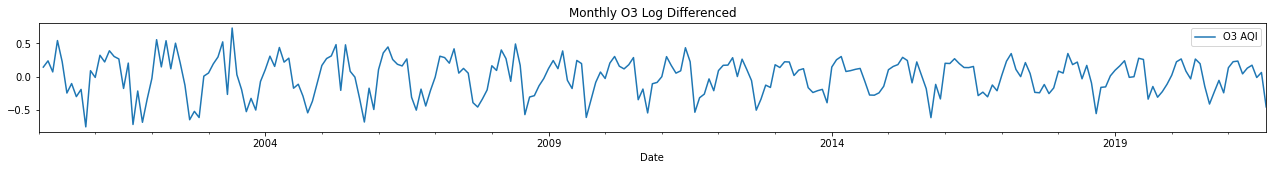

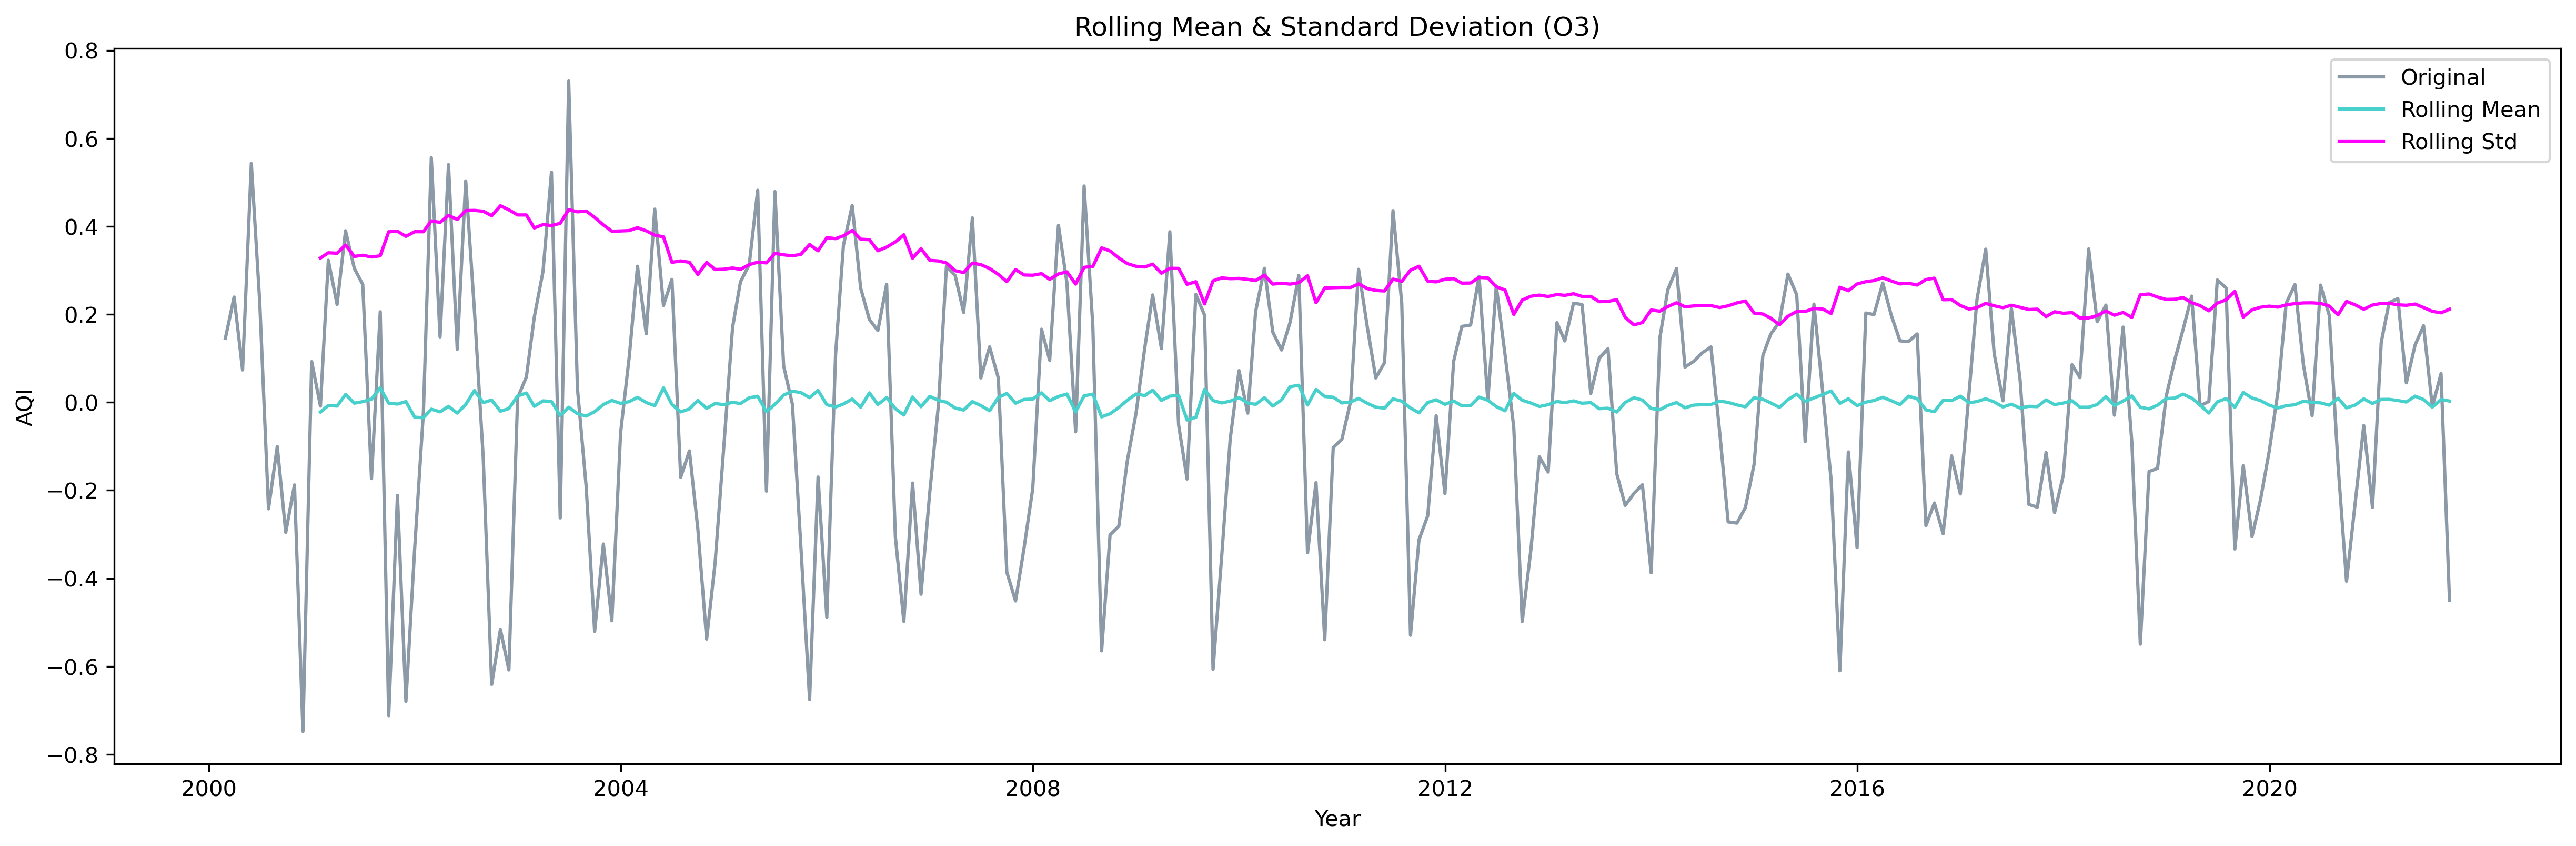

In [19]:
# Eliminating trend and seasonality
# First order differencing 
monthlyO3_log_diff = monthlyO3_log - monthlyO3_log.shift()
monthlyO3_log_diff.plot(figsize=(22,2), title='Monthly O3 Log Differenced')
monthlyO3_log_diff.dropna(inplace=True)
stationarity_check(monthlyO3_log_diff, 'O3')

In [ ]:
# Decompose 

# NEED TO FIX #

# monthlyCO_log_decompose = seasonal_decompose(monthlyCO_log).resid
# monthlyCO_log_decompose.dropna(inplace=True)
# stationarity_check(monthlyCO_log_decompose, 'CO')

In [ ]:
# ACF and PACF for daily O3 diff
lag_acf = acf(dailyO3_diff, nlags=20)
lag_pacf = pacf(dailyO3_diff, nlags=20)

# Plot ACF & PACF
plt.figure(figsize=(20,4))
plt.plot(lag_acf), plt.plot(lag_pacf)
plt.legend(['Lag ACF', 'Lag PACF']);

In [ ]:
# ACF and PACF for monthly CO log diff
lag_acf = acf(monthlyCO_log_diff, nlags=20)
lag_pacf = pacf(monthlyCO_log_diff, nlags=20)

#Plot ACF & PACF
plt.figure(figsize=(20,4))
plt.plot(lag_acf), plt.plot(lag_pacf)
plt.legend(['Lag ACF', 'Lag PACF']);

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyO3_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyO3log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# <span style="font-size:1.2em;"> <a id="Modeling">Modeling</a>

In [ ]:
dd = np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [21]:
# Generate all combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(dailyO3,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(dailyO3,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
plt.figure(figsize=(22,6), dpi=300)
ax = dailyO3['2000':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Date')
plt.ylabel('O3 AQI')
plt.legend();


In [ ]:
dailyO3_forecasted = np.exp(pred.predicted_mean)
dailyO3_real = np.exp(dailyO3['2020-01-01 00:00:00':])

"""
NEED TO FIX THIS
"""

# Compute metrics RMSE and MASE
O3_rmse = rmse(dailyO3_real, dailyO3_forecasted)
O3_mase = mase(dailyO3_real, dailyO3_forecasted)
print(O3_rmse, O3_mase)

In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyCO_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyCO_log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1165.7600595496024
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:817.4177527431933
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-86.64817594588106
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-84.62244571807231
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-149.50231659299766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-207.73117861563975
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-81.14731134557157
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-111.64651254482528
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:835.8363642495663
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:545.9558014087152
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-131.51176550747624
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-131.35977230637826


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-144.66314997242404
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-239.1983294266417
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-125.76222834762729
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-132.17668765654247
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-217.34903558970012
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-205.21208450205074
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-91.19641388669035
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-177.24484602985683
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-207.71524479465364
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-204.09631758292184
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-111.69163226727395
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-172.400988491292
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-223.07698373169364
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-215.39695743139248
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-138.94929550564348
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-218.47898141031447
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-221.6150393409527
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC

                             ARIMA Model Results                              
Dep. Variable:               D.CO AQI   No. Observations:                  261
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 110.669
Method:                           css   S.D. of innovations              0.158
Date:                Thu, 27 Jan 2022   AIC                           -217.338
Time:                        15:32:04   BIC                           -210.209
Sample:                    02-29-2000   HQIC                          -214.473
                         - 10-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0099      0.010     -1.014      0.311      -0.029       0.009


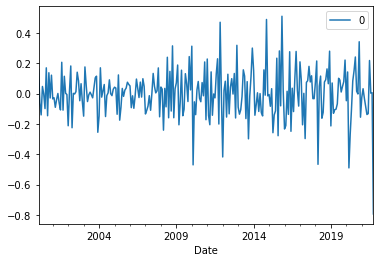

                  0
count  2.610000e+02
mean   2.276379e-09
std    1.586525e-01
min   -7.935600e-01
25%   -1.028973e-01
50%    1.663533e-03
75%    8.892361e-02
max    5.102421e-01


In [37]:
model = ARIMA(monthlyCO_log, order=(0,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [44]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

plt.figure(dpi=300)
ax = monthlyCO_log['2000':].plot(label='Observed', figsize=(18, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show();

<Figure size 1800x1200 with 0 Axes>

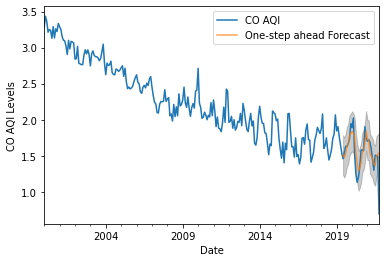

In [28]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthlyCO_log['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [33]:
mse(monthlyCO_real, monthlyCO_forecasted, squared=False)

0.7975383620703952

In [34]:
monthlyCO_forecasted = np.exp(pred.predicted_mean)
monthlyCO_real = np.exp(monthlyCO_log['2019-06-30 00:00:00':])


# Compute the mse and rmse
mase(monthlyCO_real, monthlyCO_forecasted, monthlyCO_log)

2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
2019-12-31 00:00:00   NaN
2020-01-31 00:00:00   NaN
2020-02-29 00:00:00   NaN
2020-03-31 00:00:00   NaN
2020-04-30 00:00:00   NaN
2020-05-31 00:00:00   NaN
2020-06-30 00:00:00   NaN
2020-07-31 00:00:00   NaN
2020-08-31 00:00:00   NaN
2020-09-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-30 00:00:00   NaN
2020-12-31 00:00:00   NaN
2021-01-31 00:00:00   NaN
2021-02-28 00:00:00   NaN
2021-03-31 00:00:00   NaN
2021-04-30 00:00:00   NaN
2021-05-31 00:00:00   NaN
2021-06-30 00:00:00   NaN
2021-07-31 00:00:00   NaN
2021-08-31 00:00:00   NaN
2021-09-30 00:00:00   NaN
2021-10-31 00:00:00   NaN
CO AQI                NaN
dtype: float64

In [ ]:
"""
NEED TO FIX THIS
"""
mase(monthlyCO, monthlyCO_truth, monthlyCO_forecasted)

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = monthlyCO_log['2000':].plot(label='Observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = monthlyCO_log.plot(label='Observed', figsize=(20, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

In [ ]:
arma = ARMA_model(O3, 'O3')

# mod_arma = ARMA(O3, order=(1,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(1,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arima = ARIMA(O3, order=(1,1,1), freq='D')
# O3_arima = mod_arima.fit()
# print(O3_arima.summary())

# mod_sarimax = SARIMAX(O3, order=(1,1,1), freq='D')
# O3_sarimax = mod_sarimax.fit()
# print(O3_sarimax.summary())

In [ ]:
yc = monthlyCO
yc_log=np.log(yc)
plt.plot(yc_log)
stationarity_check(yc_log, 'monthly co')

In [ ]:
# Moving average
moving_avg = yc_log.rolling(window=12).mean()
plt.plot(yc_log)
plt.plot(moving_avg, color='red')
yc_log_moving_avg_diff = yc_log - moving_avg
yc_log_moving_avg_diff.dropna(inplace=True)
stationarity_check(yc_log_moving_avg_diff, 'co')

In [ ]:
# Eliminating Trend and Seasonality
#first order differencing 
yc_log_diff = yc_log - yc_log.shift()
plt.plot(yc_log_diff)
yc_log_diff.dropna(inplace=True)
stationarity_check(yc_log_diff, 'co')

In [ ]:
# Decomposing
decomposition = seasonal_decompose(yc_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid




p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(yc_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(yc_log,
                                order=(1,0,1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = yc_log['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [ ]:
yc_forecasted = np.exp(pred.predicted_mean)
yc_truth =np.exp( yc_log['2015-06-30 00:00:00':])

# Compute the mean square error
mse =( (yc_forecasted - yc_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = yc_log['2000':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), yc_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
yc_forecasted = np.exp(pred_dynamic.predicted_mean)
yc_truth = np.exp(yc_log['1998-01-01':])

# Compute the mean square error
mse = ((yc_forecasted - yc_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = yc_log.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

# <span style="font-size:1.2em;"> <a id="Visualizations">Visualizations</a>

In [ ]:
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)
df.info()

In [ ]:
# Creating list of daily AQI per pollutant
dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]

# Downsampling from days to months
monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
monthlyCO = df.copy()['CO AQI'].resample('M').mean()
monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]

In [ ]:
# Plotting daily AQI
plt.figure(figsize=(20,6), dpi=300)
dailys[0].plot(color='magenta', alpha=0.7)
dailys[1].plot(color='#61d4c1', alpha=0.7)
dailys[2].plot(color='#4527d9', alpha=0.7)
dailys[3].plot(color='#ffd500', alpha=0.7)
plt.title('Daily AQI')
plt.ylabel('AQI')
plt.legend();

In [ ]:
# Plotting monthly AQI
plt.figure(figsize=(20,6), dpi=300)
monthlys[0].plot(color='magenta')
monthlys[1].plot(color='#61d4c1')
monthlys[2].plot(color='#4527d9')
monthlys[3].plot(color='#ffd500')
plt.title('Monthly AQI')
plt.ylabel('AQI')
plt.legend();

# <span style="font-size:1.2em;"> <a id="Conclusion">Conclusion</a>

> In conclusion, my SARIMA model forecasted air quality in New York City quite well and could even be used in shaping government policy on public health. I would recommend implementing measures to decrease the presence of air pollutants, especially ozone and nitrogen dioxide, as there hasn't been much decrease from 2000.

# <span style="font-size:1.2em;"> <a id="Next Steps">Next Steps</a>

> Given more time and resources, I would like to explore beyond New York City, modeling for other cities and even seeing how cities compare to suburban or rural areas. Another pollutant I'd like to consider is particulate matter. In terms of modeling, it would be interesting to see how well a recurrent neural network would perform.

Function sources:

https://www.kaggle.com/victoraqiao/time-series-forecasting-arima-co-aqi

MASE:
https://github.com/scikit-learn/scikit-learn/issues/18685